In [1]:
# import standard numerical modules
import numpy as np
import math
import tensorflow as tf
import gc

import DCTR


2024-04-23 12:59:35.427063: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-23 12:59:35.427090: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [47]:
from importlib import reload
reload(DCTR)


<module 'DCTR' from '/home/finn/gdrive/_STUDIUM_/DCTR_Paper/git/DCTR_FP/DCTR.py'>

In [2]:
data_dir = './Data/'


In [3]:
# Load pre-normed Datasets: MiNNLO: X1 | POWHEG hvq: X0
# only contain tt-pair; every event has order: 
# tt-pair, top, anti-top
# every particle has arguments: 
# [pt, y, phi, mass, eta, E, PID, w, theta]
# [0 , 1, 2  , 3   , 4  , 5, 6  , 7, 8    ]

# POWHEG hvq
# plotting data; different from training data
X0_plt = []
X0_plt = DCTR.load_dataset(f'{data_dir}/POWHEG_hvq/13TeV/03-04_converted_lhe.npz', i=3)[:9553938] # 9553938 num of MiNNLO samples
print('POWHEG hvq all particles X0_plt.shape: '+str(X0_plt.shape))

X0_test = []
X0_test = DCTR.load_dataset(f'{data_dir}/POWHEG_hvq/13TeV/03-04_normed_converted_lhe.npz', i=3)[:9553938]
print('POWHEG hvq all particles X0_test.shape: '+str(X0_test.shape))

print(gc.collect())


POWHEG hvq all particles X0_plt.shape: (9553938, 3, 9)
POWHEG hvq all particles X0_test.shape: (9553938, 3, 9)
183


In [4]:
# MiNNLO
# plotting data
X1_plt = []
X1_plt = DCTR.load_dataset(f'{data_dir}/MiNNLO/converted_with_13TeV_NLO/converted_lhe.npz', i=3)
print('MiNNLO all particles X1_plt.shape: '+str(X1_plt.shape))


MiNNLO all particles X1_plt.shape: (9553938, 3, 9)


In [5]:
# get event generator weights

X0_plt_wgt = X0_plt[:, 0, 7].copy()
X1_plt_wgt = X1_plt[:, 0, 7].copy()


In [6]:
print(f'X0_plt_wgt (min, max, mean): {min(X0_plt_wgt), max(X0_plt_wgt), np.mean(X0_plt_wgt)}')
print(f'X1_plt_wgt (min, max, mean): {min(X1_plt_wgt), max(X1_plt_wgt), np.mean(X1_plt_wgt)}')


X0_plt_wgt (min, max, mean): (-692.465, 692.465, 686.4671955083866)
X1_plt_wgt (min, max, mean): (-103.245, 103.245, 83.13098417846136)


In [7]:
# delete energy from (normalized) testing dataset, since the neural network was trained without these parameters
X0_test = np.delete(X0_test, 5, -1)

# delete eta
X0_test = np.delete(X0_test, 4, -1)

# garbage collection
print(gc.collect())


0


# bin reweighting

# 1D Bin Reweighting 
using ratio of histograms and hep_ml.reweight.BinsReweighter()


In [32]:
from hep_ml.reweight import BinsReweighter

start, stop, div = (0, 1000, 19)
# create 1D Histograms of X0 and X1 of p_T(tt)
bins = np.linspace(start, stop, div)

n0, bins = np.histogram(X0_plt[:,0, 0], bins, density=True, weights=X0_plt_wgt)
n1, bins = np.histogram(X1_plt[:,0, 0], bins, density=True, weights=X1_plt_wgt)

ratio = np.divide(n1, n0)

# set new weights for X0 as old_wgt * ratio in each bin
X0_1D_rwgt = [] # Initialize an empty list to store weights
# Loop through each event in X0_plt[:,0, 0]
for i, pt in enumerate(X0_plt[:,0, 0]):
    # Find the bin index for the event
    bin_index = np.digitize(pt, bins=bins)
    
    # Get the corresponding ratio for this bin
    if bin_index > 0 and bin_index < len(ratio):
        event_ratio = ratio[bin_index - 1]  # Adjust for zero-based indexing
    elif bin_index >= len(ratio):
        event_ratio = ratio[-1]  # Use last bin ratio
    else:
        event_ratio = ratio[bin_index - 1]  # Adjust for zero-based indexing
    
    X0_1D_rwgt.append(event_ratio * X0_plt_wgt[i])

# Convert the weights list to a NumPy array
X0_1D_rwgt = np.array(X0_1D_rwgt)


'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


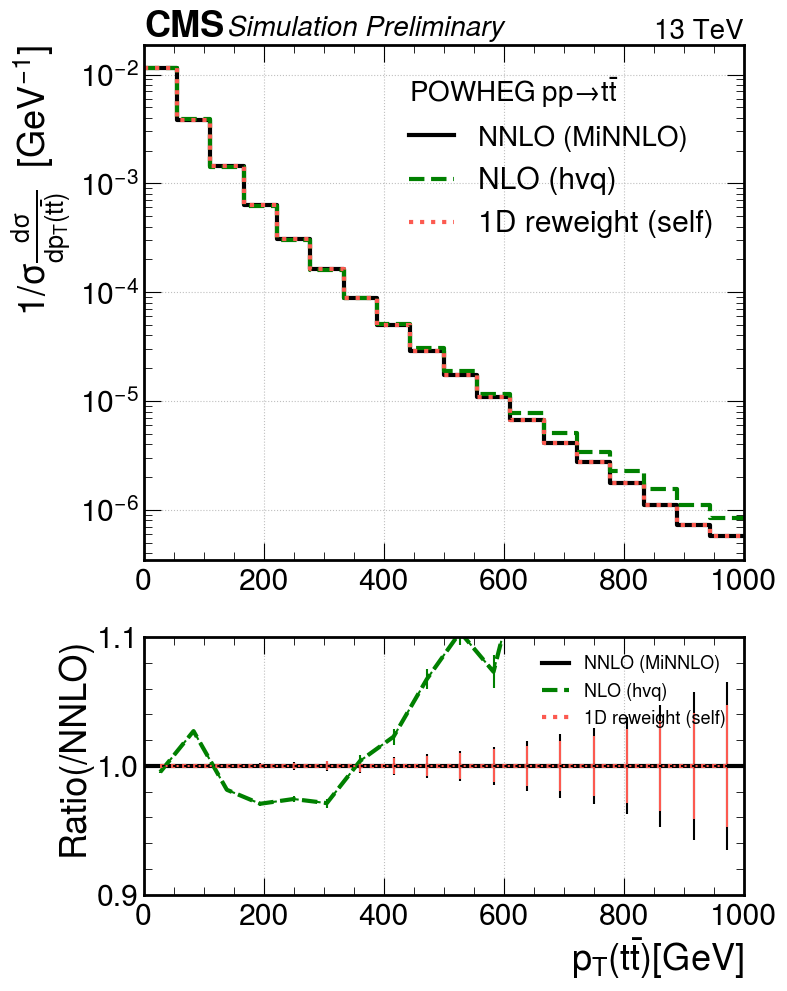

'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


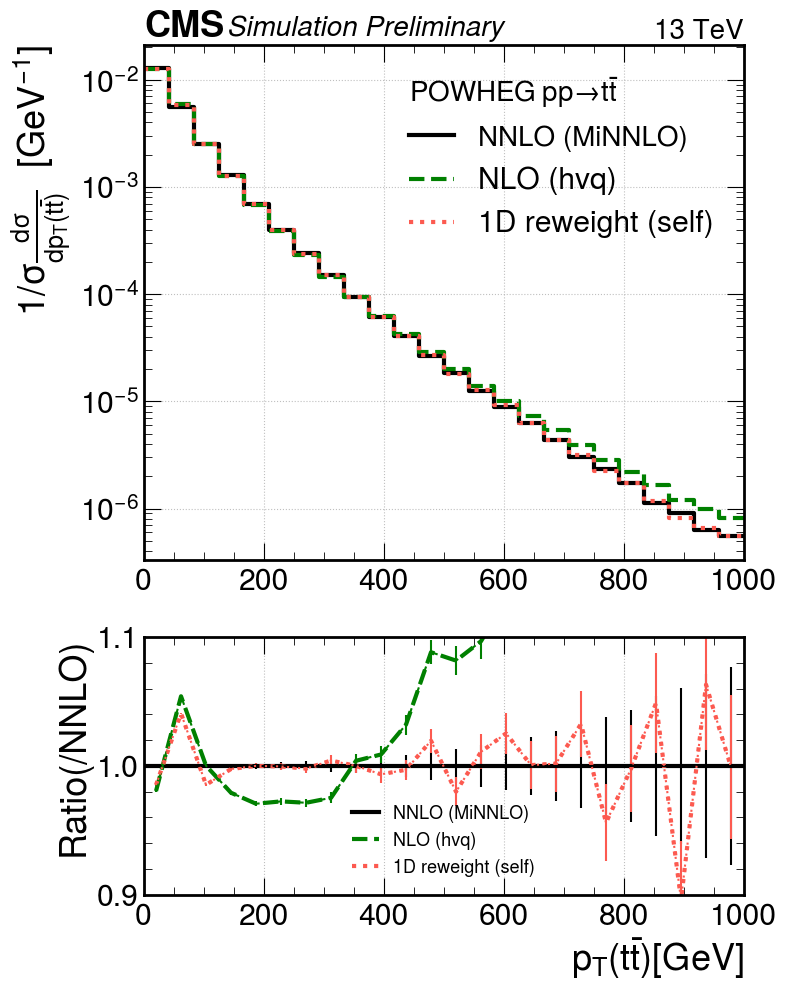

In [37]:
# setup args for plotting
args_bin = [(X1_plt, X1_plt_wgt, 'NNLO (MiNNLO)'),
            (X0_plt, X0_plt_wgt, 'NLO (hvq)'),
            (X0_plt, X0_1D_rwgt, '1D reweight (self)')]


# p_T(tt)
DCTR.plot_ratio_cms(args_bin, arg_index=0, part_index=0, start = start, stop = stop, div=19, y_scale='log', ratio_ylim=[0.9,1.1], save_prefix='1D_lin_1000_19-19')
DCTR.plot_ratio_cms(args_bin, arg_index=0, part_index=0, start = start, stop = stop, div=25, y_scale='log', ratio_ylim=[0.9,1.1], save_prefix='1D_lin_1000_19-25')


# 2D bin rwgt using m(tt) and p_T(t)

In [51]:
''' # using m(tt) and p_T(t)
X0_bin_rwgt_org = []
X1_bin_rwgt_target = []

# decide which (2) dimensions to do the bin rwgt along
X0_bin_rwgt_org.append(X0_plt[:,0,3]) # m(tt)
X0_bin_rwgt_org.append(X0_plt[:,1,0]) # p_T(t)
X0_bin_rwgt_org = np.transpose(X0_bin_rwgt_org) # wants to be [num_samples, num_dim]

X1_bin_rwgt_target.append(X1_plt[:,0,3]) # m(tt)
X1_bin_rwgt_target.append(X1_plt[:,1,0]) # p_T(t)
X1_bin_rwgt_target = np.transpose(X1_bin_rwgt_target)

# print(f'X0_bin_rwgt_org: {np.array(X0_bin_rwgt_org)}')
# print(f'X1_bin_rwgt_target: {np.array(X1_bin_rwgt_target)}')

# print(f'X0_bin_rwgt_org.shape: {np.shape(X0_bin_rwgt_org)}')
# print(f'X0_plt_wgt length: {len(X0_plt_wgt)}')
# print(f'X1_bin_rwgt_target.shape: {np.shape(X1_bin_rwgt_target)}')
# print(f'X1_plt_wgt length: {len(X1_plt_wgt)}')
'''

# using p_T(tt) and eta(tt)
X0_bin_rwgt_org = []
X1_bin_rwgt_target = []

# decide which (2) dimensions to do the bin rwgt along
X0_bin_rwgt_org.append(X0_plt[:,0,0]) # p_T(tt)
X0_bin_rwgt_org.append(X0_plt[:,0,4]) # eta(tt)
X0_bin_rwgt_org = np.transpose(X0_bin_rwgt_org) # wants to be [num_samples, num_dim]

X1_bin_rwgt_target.append(X1_plt[:,0,0]) # p_T(tt)
X1_bin_rwgt_target.append(X1_plt[:,0,4]) # eta(tt)
X1_bin_rwgt_target = np.transpose(X1_bin_rwgt_target)

# print(f'X0_bin_rwgt_org: {np.array(X0_bin_rwgt_org)}')
# print(f'X1_bin_rwgt_target: {np.array(X1_bin_rwgt_target)}')

# print(f'X0_bin_rwgt_org.shape: {np.shape(X0_bin_rwgt_org)}')
# print(f'X0_plt_wgt length: {len(X0_plt_wgt)}')
# print(f'X1_bin_rwgt_target.shape: {np.shape(X1_bin_rwgt_target)}')
# print(f'X1_plt_wgt length: {len(X1_plt_wgt)}')



In [52]:
# test different bin reweighter setups for the best results
# 19 bins
# 19 bins, 1 bin gauss filter
bin_reweighter_19_1 = BinsReweighter(n_bins=19, n_neighs=1) 
bin_reweighter_19_1.fit(original=X0_bin_rwgt_org, target=X1_bin_rwgt_target,
               original_weight=X0_plt_wgt, target_weight=X1_plt_wgt)
bin_rwgt_19_1 = bin_reweighter_19_1.predict_weights(X0_bin_rwgt_org, original_weight=X0_plt_wgt)

# 19 bins, 2 bin gauss filter
bin_reweighter_19_2 = BinsReweighter(n_bins=19, n_neighs=2) 
bin_reweighter_19_2.fit(original=X0_bin_rwgt_org, target=X1_bin_rwgt_target,
               original_weight=X0_plt_wgt, target_weight=X1_plt_wgt)
bin_rwgt_19_2 = bin_reweighter_19_2.predict_weights(X0_bin_rwgt_org, original_weight=X0_plt_wgt)

# 19 bins, 3 bin gauss filter
bin_reweighter_19_3 = BinsReweighter(n_bins=19, n_neighs=3) 
bin_reweighter_19_3.fit(original=X0_bin_rwgt_org, target=X1_bin_rwgt_target,
               original_weight=X0_plt_wgt, target_weight=X1_plt_wgt)
bin_rwgt_19_3 = bin_reweighter_19_3.predict_weights(X0_bin_rwgt_org, original_weight=X0_plt_wgt)


# 25 bins
# 25 bins, 1 bin gauss filter
bin_reweighter_25_1 = BinsReweighter(n_bins=25, n_neighs=1) 
bin_reweighter_25_1.fit(original=X0_bin_rwgt_org, target=X1_bin_rwgt_target,
               original_weight=X0_plt_wgt, target_weight=X1_plt_wgt)
bin_rwgt_25_1 = bin_reweighter_25_1.predict_weights(X0_bin_rwgt_org, original_weight=X0_plt_wgt)

# 25 bins, 2 bin gauss filter
bin_reweighter_25_2 = BinsReweighter(n_bins=25, n_neighs=2) 
bin_reweighter_25_2.fit(original=X0_bin_rwgt_org, target=X1_bin_rwgt_target,
               original_weight=X0_plt_wgt, target_weight=X1_plt_wgt)
bin_rwgt_25_2 = bin_reweighter_25_2.predict_weights(X0_bin_rwgt_org, original_weight=X0_plt_wgt)

# 25 bins, 3 bin gauss filter
bin_reweighter_25_3 = BinsReweighter(n_bins=25, n_neighs=3) 
bin_reweighter_25_3.fit(original=X0_bin_rwgt_org, target=X1_bin_rwgt_target,
               original_weight=X0_plt_wgt, target_weight=X1_plt_wgt)
bin_rwgt_25_3 = bin_reweighter_25_3.predict_weights(X0_bin_rwgt_org, original_weight=X0_plt_wgt)


# 31 bins
# 31 bins, 1 bin gauss filter
bin_reweighter_31_1 = BinsReweighter(n_bins=31, n_neighs=1) 
bin_reweighter_31_1.fit(original=X0_bin_rwgt_org, target=X1_bin_rwgt_target,
               original_weight=X0_plt_wgt, target_weight=X1_plt_wgt)
bin_rwgt_31_1 = bin_reweighter_31_1.predict_weights(X0_bin_rwgt_org, original_weight=X0_plt_wgt)

# 31 bins, 2 bin gauss filter
bin_reweighter_31_2 = BinsReweighter(n_bins=31, n_neighs=2) 
bin_reweighter_31_2.fit(original=X0_bin_rwgt_org, target=X1_bin_rwgt_target,
               original_weight=X0_plt_wgt, target_weight=X1_plt_wgt)
bin_rwgt_31_2 = bin_reweighter_31_2.predict_weights(X0_bin_rwgt_org, original_weight=X0_plt_wgt)

# 31 bins, 3 bin gauss filter
bin_reweighter_31_3 = BinsReweighter(n_bins=31, n_neighs=3) 
bin_reweighter_31_3.fit(original=X0_bin_rwgt_org, target=X1_bin_rwgt_target,
               original_weight=X0_plt_wgt, target_weight=X1_plt_wgt)
bin_rwgt_31_3 = bin_reweighter_31_3.predict_weights(X0_bin_rwgt_org, original_weight=X0_plt_wgt)



In [54]:
# setup args for plotting
args_19 = [(X1_plt, X1_plt_wgt, 'NNLO (MiNNLO)'),
            (X0_plt, X0_plt_wgt, 'NLO (hvq)'),
            (X0_plt, bin_rwgt_19_1, 'bin_rwgt_19_1'),
            (X0_plt, bin_rwgt_19_2, 'bin_rwgt_19_2'),
            (X0_plt, bin_rwgt_19_3, 'bin_rwgt_19_3')]

args_25 = [(X1_plt, X1_plt_wgt, 'NNLO (MiNNLO)'),
            (X0_plt, X0_plt_wgt, 'NLO (hvq)'),
            (X0_plt, bin_rwgt_25_1, 'bin_rwgt_25_1'),
            (X0_plt, bin_rwgt_25_2, 'bin_rwgt_25_2'),
            (X0_plt, bin_rwgt_25_3, 'bin_rwgt_25_3')]


args_31 = [(X1_plt, X1_plt_wgt, 'NNLO (MiNNLO)'),
            (X0_plt, X0_plt_wgt, 'NLO (hvq)'),
            (X0_plt, bin_rwgt_31_1, 'bin_rwgt_31_1'),
            (X0_plt, bin_rwgt_31_2, 'bin_rwgt_31_2'),
            (X0_plt, bin_rwgt_31_3, 'bin_rwgt_31_3')]


args_n1 = [(X1_plt, X1_plt_wgt, 'NNLO (MiNNLO)'),
            (X0_plt, X0_plt_wgt, 'NLO (hvq)'),
            (X0_plt, bin_rwgt_19_1, 'bin_rwgt_19_1'),
            (X0_plt, bin_rwgt_25_1, 'bin_rwgt_25_1'),
            (X0_plt, bin_rwgt_31_1, 'bin_rwgt_31_1')]


NNLO (MiNNLO): mean: 61.623, std: 72.536, max/min: 1881.821853030107/0.001743452831167295 
 Mean Absolute Error 0.0 
 Mean Relative Error 0.0 
 reduced chi square of 0.0 with p 1.0 
 compared to NNLO (MiNNLO)
NLO (hvq): mean: 62.866, std: 73.082, max/min: 2386.6179856322683/0.012179553537007322 
 Mean Absolute Error 1861241.4137852388 
 Mean Relative Error 0.045165063136657475 
 reduced chi square of 17.20722880856471 with p 3.9213523845053075e-52 
 compared to NNLO (MiNNLO)
bin_rwgt_19_1: mean: 62.096, std: 74.147, max/min: 2386.6179856322683/0.012179553537007322 
 Mean Absolute Error 167315.74565904294 
 Mean Relative Error 0.0383914763639124 
 reduced chi square of 0.8763549166363735 with p 0.6028260893483849 
 compared to NNLO (MiNNLO)
bin_rwgt_25_1: mean: 62.089, std: 74.127, max/min: 2386.6179856322683/0.012179553537007322 
 Mean Absolute Error 170686.32926760675 
 Mean Relative Error 0.03742768226779498 
 reduced chi square of 0.8500568294212445 with p 0.6349624125193383 
 compa

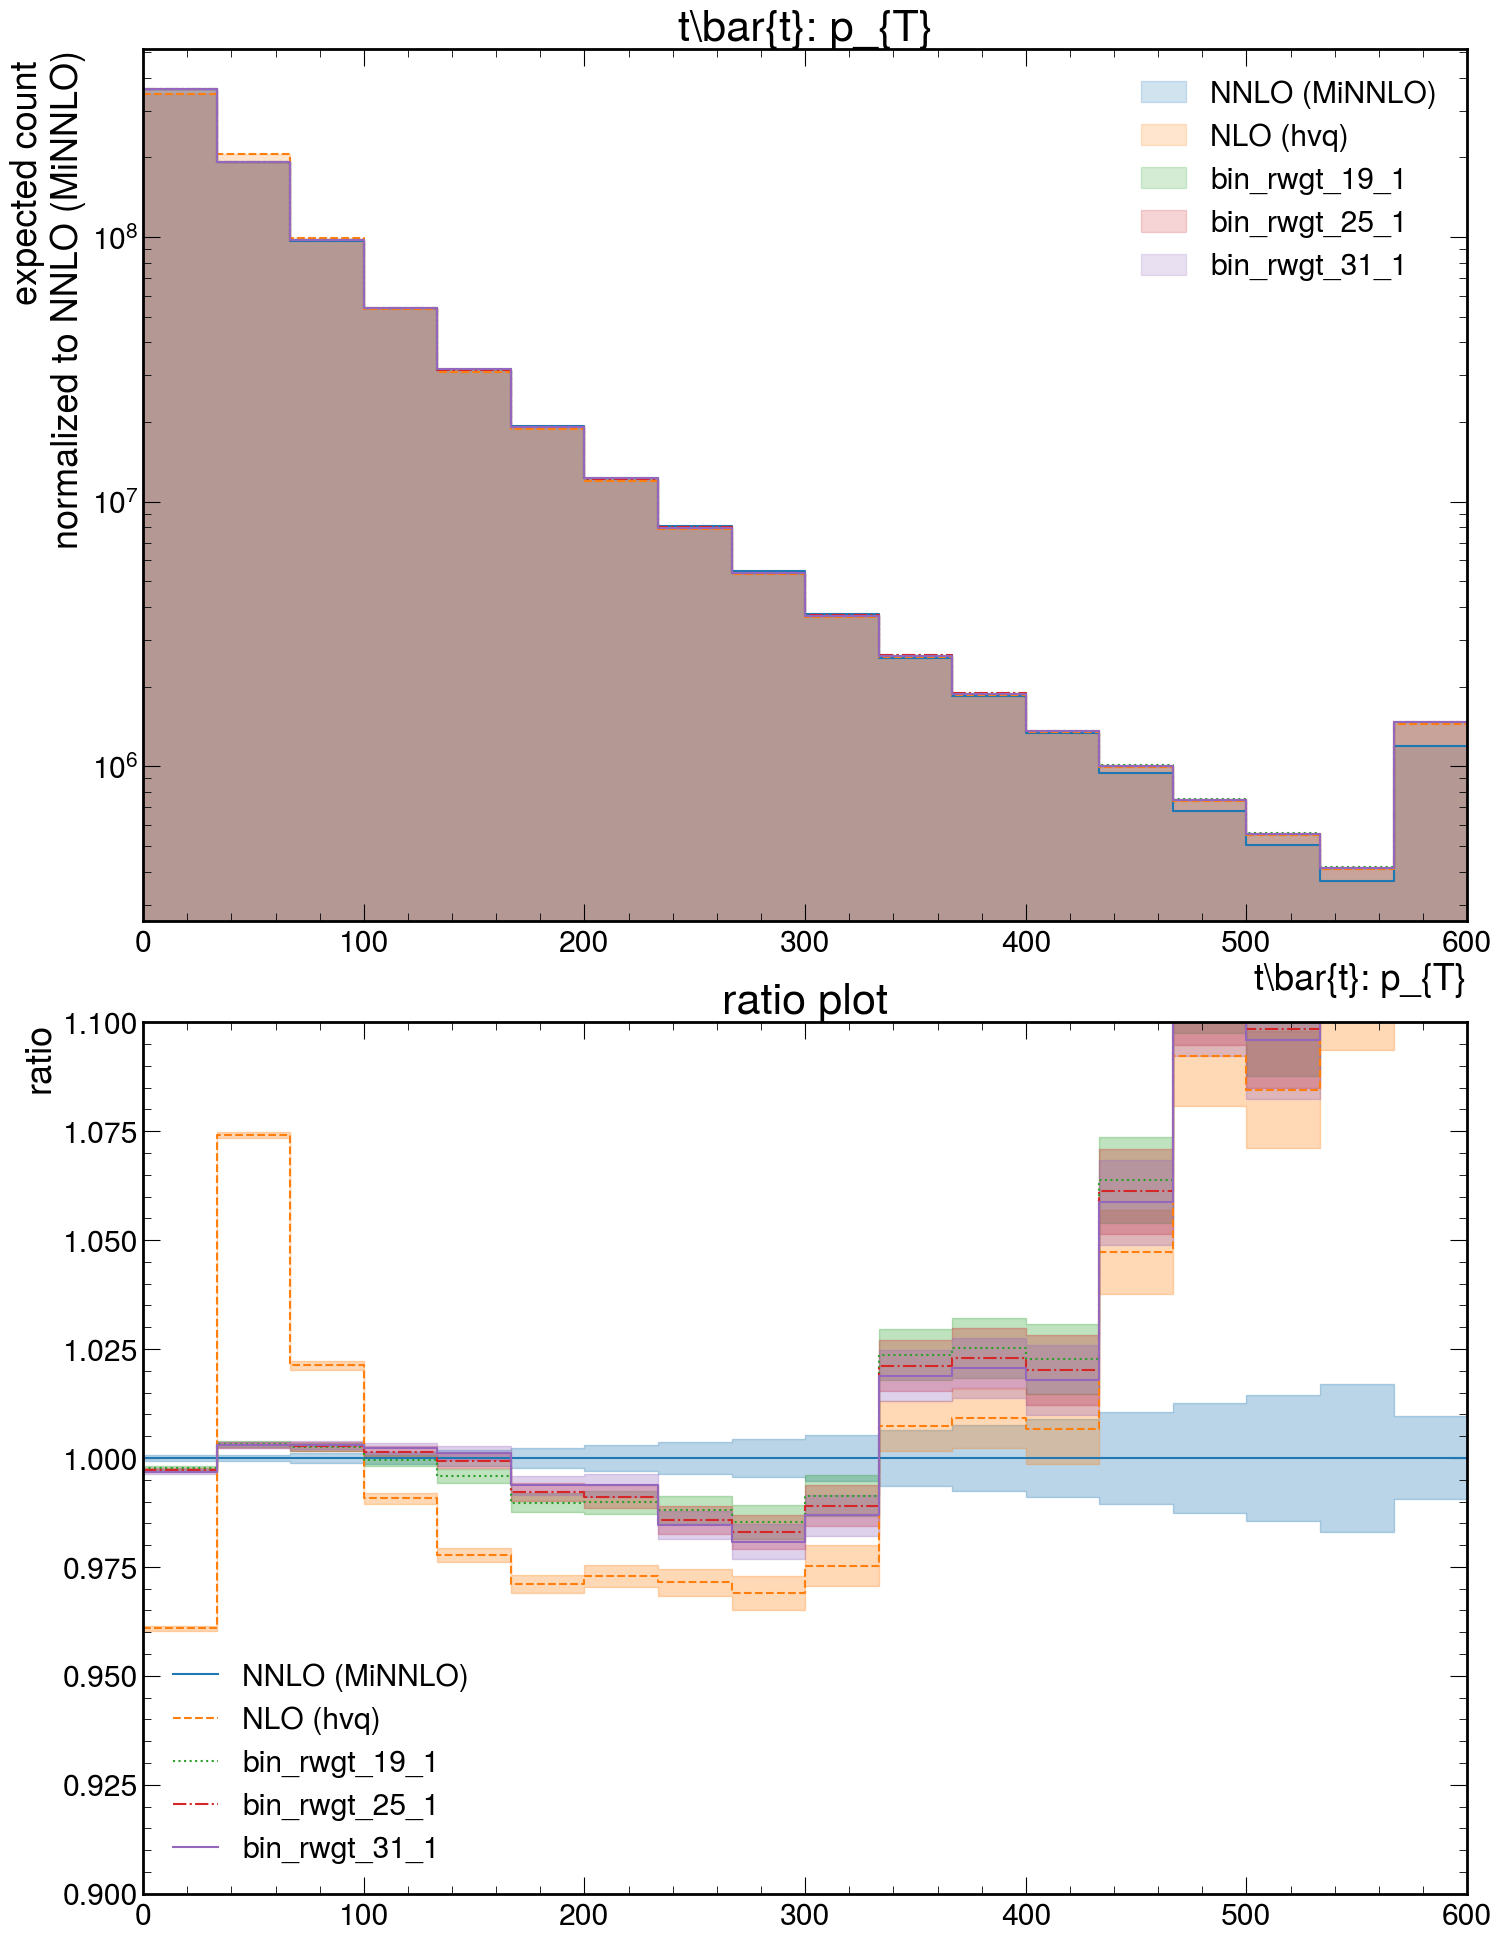

NNLO (MiNNLO): mean: 61.623, std: 72.536, max/min: 1881.821853030107/0.001743452831167295 
 Mean Absolute Error 0.0 
 Mean Relative Error 0.0 
 reduced chi square of 0.0 with p 1.0 
 compared to NNLO (MiNNLO)
NLO (hvq): mean: 62.866, std: 73.082, max/min: 2386.6179856322683/0.012179553537007322 
 Mean Absolute Error 1861241.4137852388 
 Mean Relative Error 0.045165063136657475 
 reduced chi square of 17.20722880856471 with p 3.9213523845053075e-52 
 compared to NNLO (MiNNLO)
bin_rwgt_19_1: mean: 62.096, std: 74.147, max/min: 2386.6179856322683/0.012179553537007322 
 Mean Absolute Error 167315.74565904294 
 Mean Relative Error 0.0383914763639124 
 reduced chi square of 0.8763549166363735 with p 0.6028260893483849 
 compared to NNLO (MiNNLO)
bin_rwgt_19_2: mean: 62.009, std: 73.983, max/min: 2386.6179856322683/0.012179553537007322 
 Mean Absolute Error 187851.25575524295 
 Mean Relative Error 0.039436661254937076 
 reduced chi square of 1.0003329275980404 with p 0.45398272347245755 
 com

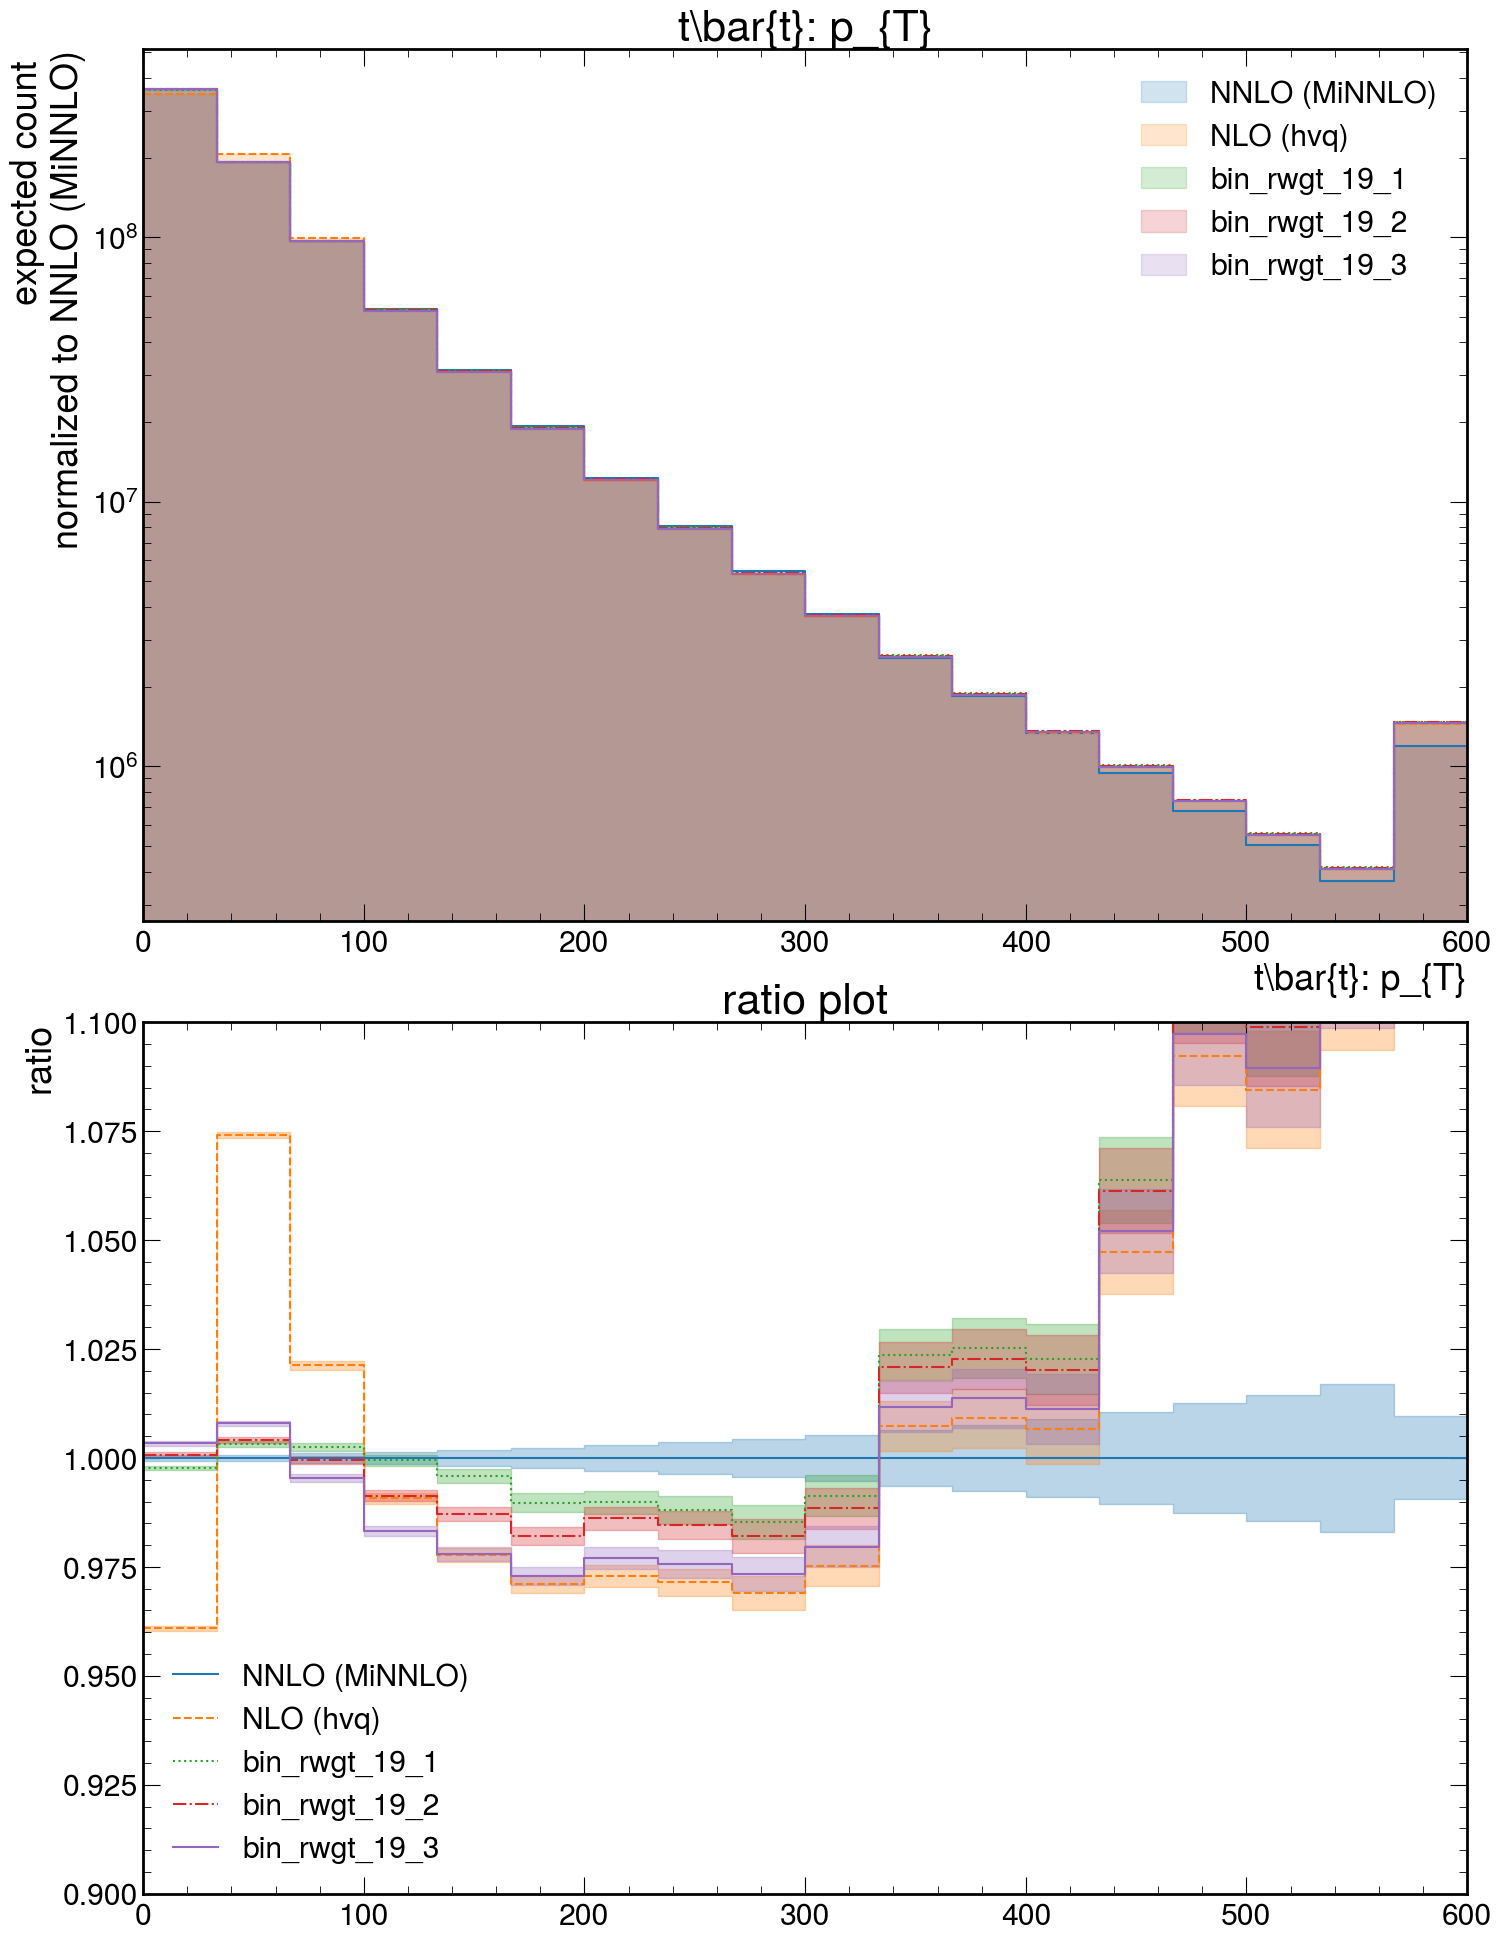

NNLO (MiNNLO): mean: 61.623, std: 72.536, max/min: 1881.821853030107/0.001743452831167295 
 Mean Absolute Error 0.0 
 Mean Relative Error 0.0 
 reduced chi square of 0.0 with p 1.0 
 compared to NNLO (MiNNLO)
NLO (hvq): mean: 62.866, std: 73.082, max/min: 2386.6179856322683/0.012179553537007322 
 Mean Absolute Error 1861241.4137852388 
 Mean Relative Error 0.045165063136657475 
 reduced chi square of 17.20722880856471 with p 3.9213523845053075e-52 
 compared to NNLO (MiNNLO)
bin_rwgt_25_1: mean: 62.089, std: 74.127, max/min: 2386.6179856322683/0.012179553537007322 
 Mean Absolute Error 170686.32926760675 
 Mean Relative Error 0.03742768226779498 
 reduced chi square of 0.8500568294212445 with p 0.6349624125193383 
 compared to NNLO (MiNNLO)
bin_rwgt_25_2: mean: 62.068, std: 74.094, max/min: 2386.6179856322683/0.012179553537007322 
 Mean Absolute Error 161652.32908838848 
 Mean Relative Error 0.03907336565006494 
 reduced chi square of 0.9109959506099854 with p 0.5604523293588071 
 comp

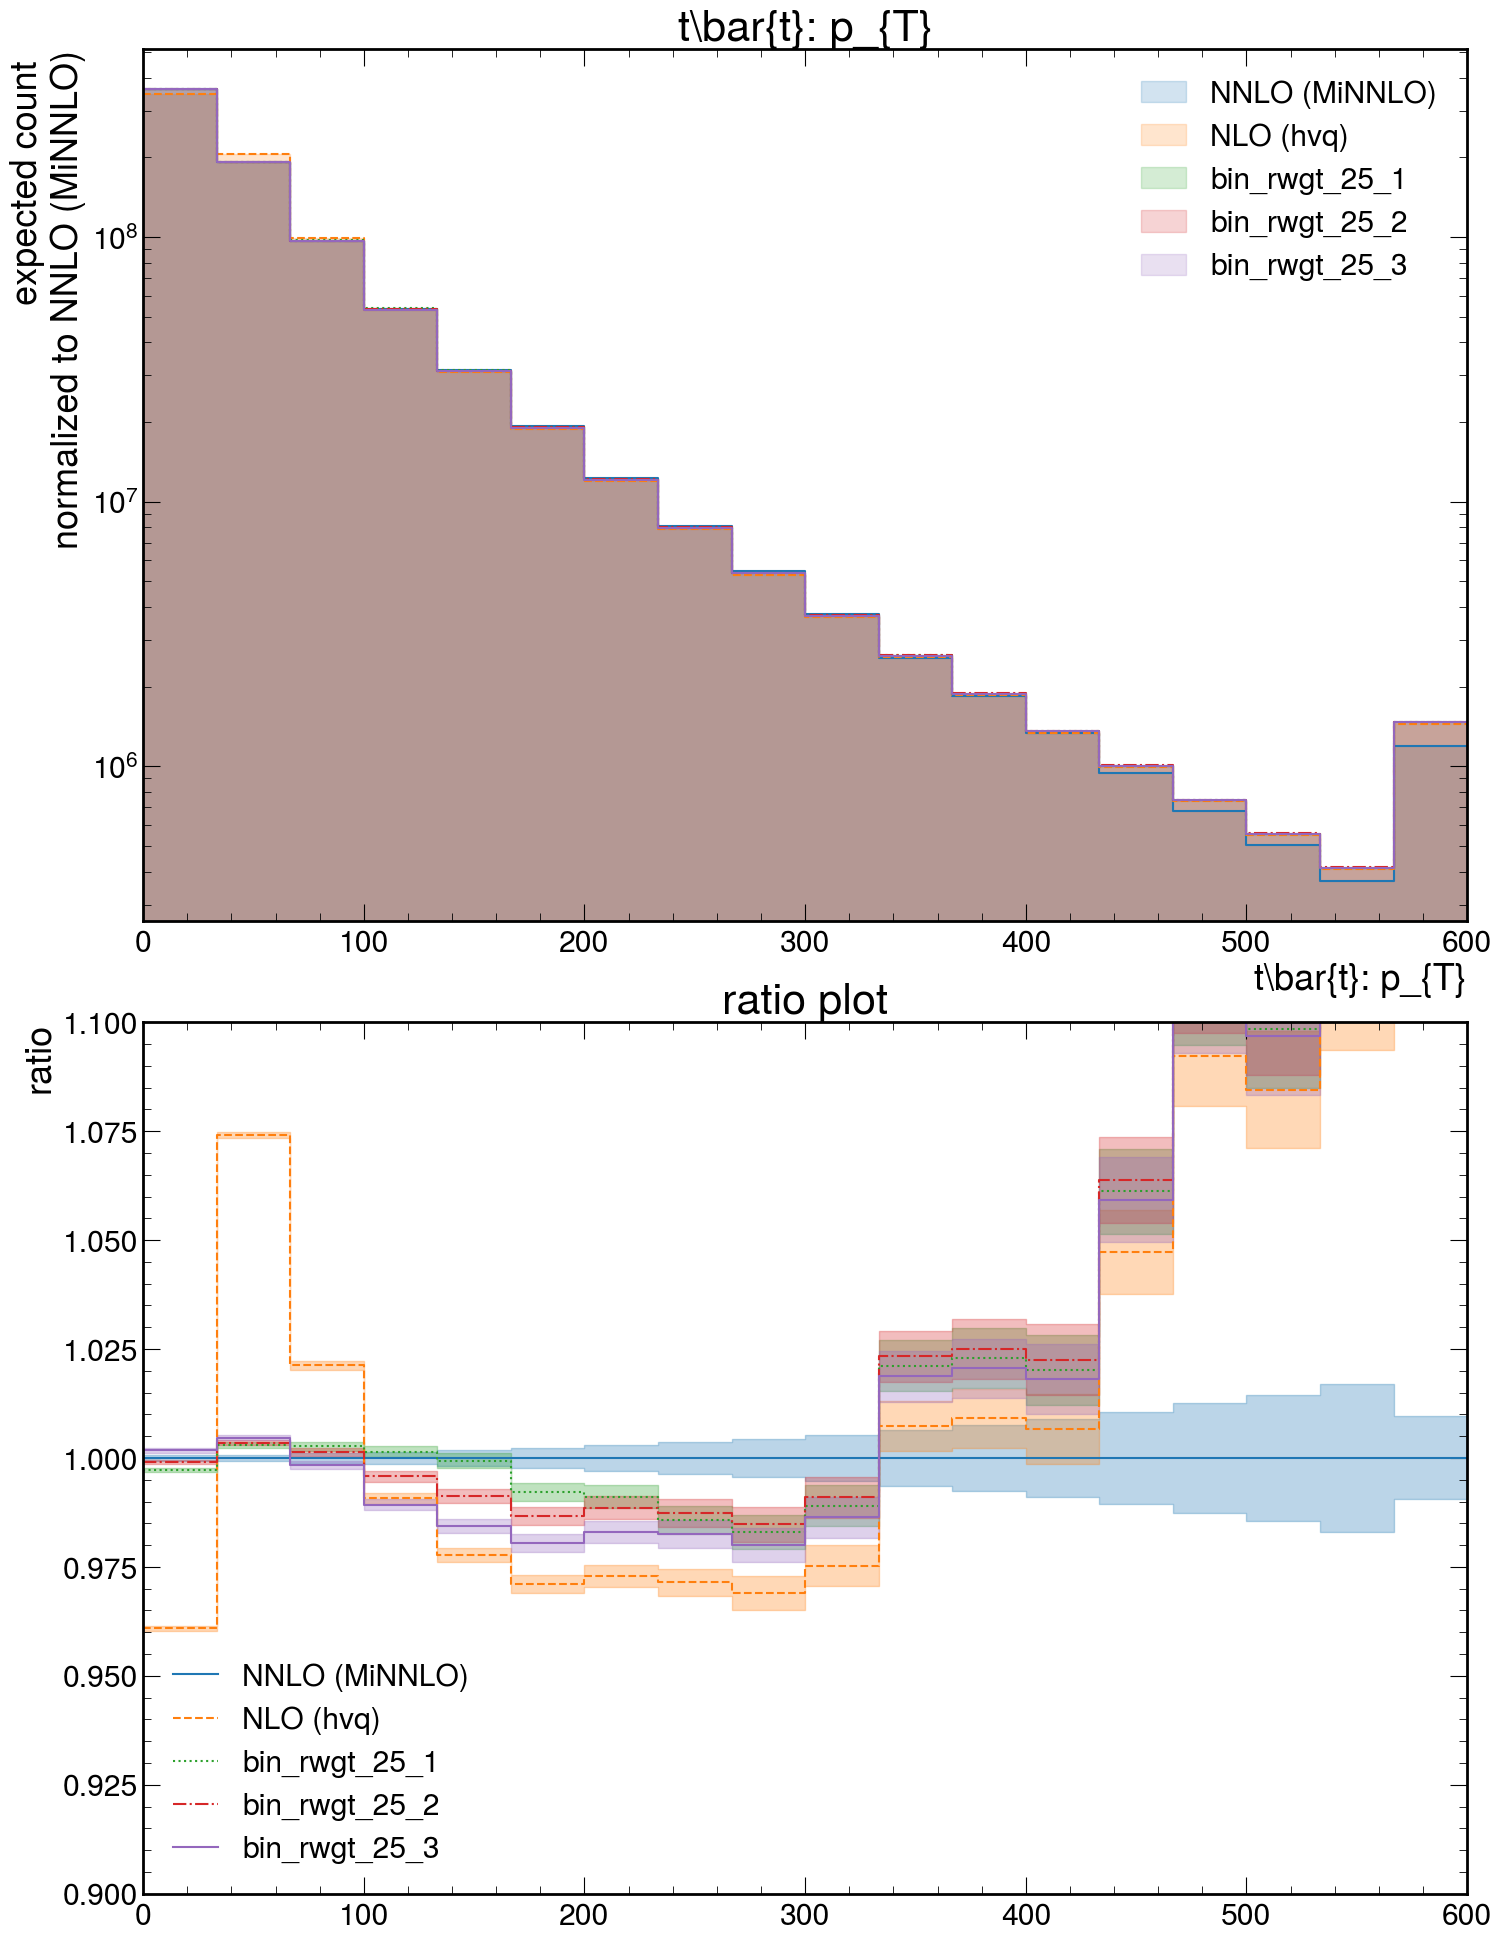

NNLO (MiNNLO): mean: 61.623, std: 72.536, max/min: 1881.821853030107/0.001743452831167295 
 Mean Absolute Error 0.0 
 Mean Relative Error 0.0 
 reduced chi square of 0.0 with p 1.0 
 compared to NNLO (MiNNLO)
NLO (hvq): mean: 62.866, std: 73.082, max/min: 2386.6179856322683/0.012179553537007322 
 Mean Absolute Error 1861241.4137852388 
 Mean Relative Error 0.045165063136657475 
 reduced chi square of 17.20722880856471 with p 3.9213523845053075e-52 
 compared to NNLO (MiNNLO)
bin_rwgt_31_1: mean: 62.082, std: 74.104, max/min: 2386.6179856322683/0.012179553537007322 
 Mean Absolute Error 179715.75410245045 
 Mean Relative Error 0.03664973866811704 
 reduced chi square of 0.8347172119274113 with p 0.6535961605631877 
 compared to NNLO (MiNNLO)
bin_rwgt_31_2: mean: 62.096, std: 74.136, max/min: 2386.6179856322683/0.012179553537007322 
 Mean Absolute Error 170017.59887438364 
 Mean Relative Error 0.038632789463380904 
 reduced chi square of 0.8881048627733766 with p 0.5884385182945973 
 com

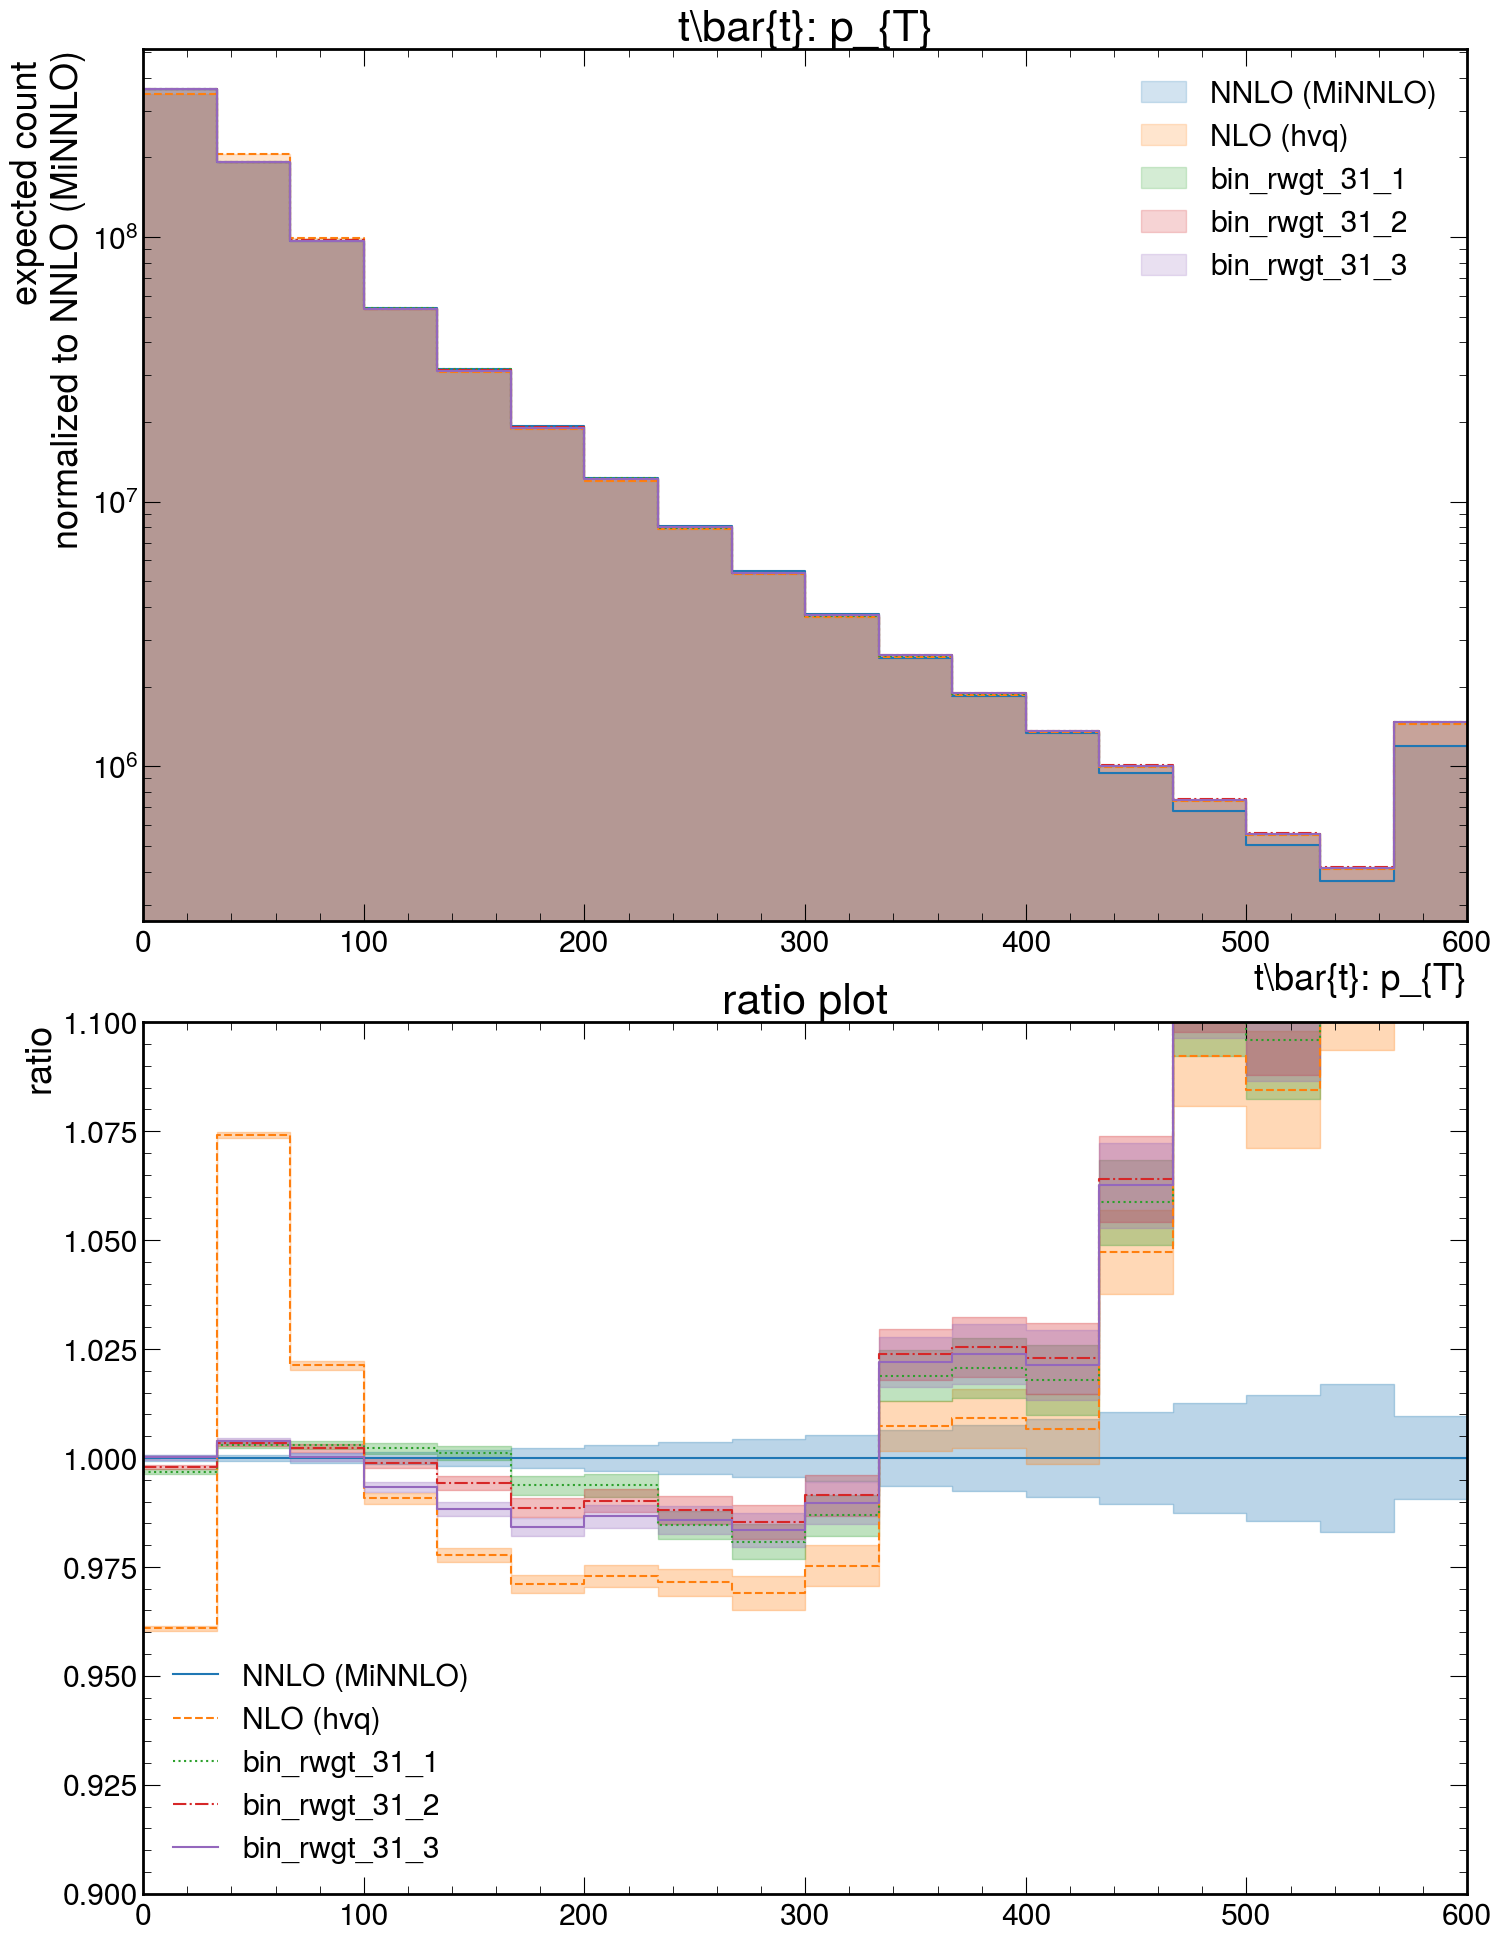

([0.0,
  1861241.4137852388,
  179715.75410245045,
  170017.59887438364,
  160205.40435377057],
 [0.0,
  17.20722880856471,
  0.8347172119274113,
  0.8881048627733766,
  0.9584139567645683],
 [1.0,
  3.9213523845053075e-52,
  0.6535961605631877,
  0.5884385182945973,
  0.5031644329249236])

In [55]:
# plotting p_T(tt)
# comparing different binnings
DCTR.plot_ratio(args_n1, arg_index = 0, part_index = 0, start = 0, stop = 600, div=19, y_scale='log')

# comparing different n_neighs to take into consideration (gauss filter in bins)
DCTR.plot_ratio(args_19, arg_index = 0, part_index = 0, start = 0, stop = 600, div=19, y_scale='log')

DCTR.plot_ratio(args_25, arg_index = 0, part_index = 0, start = 0, stop = 600, div=19, y_scale='log')

DCTR.plot_ratio(args_31, arg_index = 0, part_index = 0, start = 0, stop = 600, div=19, y_scale='log')



NNLO (MiNNLO): mean: 0.001, std: 3.417, max/min: 13.830049878532156/-13.20077537478709 
 Mean Absolute Error 0.0 
 Mean Relative Error 0.0 
 reduced chi square of 0.0 with p 1.0 
 compared to NNLO (MiNNLO)
NLO (hvq): mean: -0.000, std: 3.291, max/min: 10.023277969879556/-11.59612611504899 
 Mean Absolute Error 2441796.2402861733 
 Mean Relative Error 0.303153606196777 
 reduced chi square of 116.69454580853436 with p 0.0 
 compared to NNLO (MiNNLO)
bin_rwgt_19_1: mean: 0.000, std: 3.402, max/min: 10.023277969879556/-11.59612611504899 
 Mean Absolute Error 232502.73179288144 
 Mean Relative Error 0.052063027288774905 
 reduced chi square of 3.8856641572139976 with p 1.0181728772920213e-07 
 compared to NNLO (MiNNLO)
bin_rwgt_25_1: mean: 0.000, std: 3.406, max/min: 10.023277969879556/-11.59612611504899 
 Mean Absolute Error 167151.28828650943 
 Mean Relative Error 0.03560114577089667 
 reduced chi square of 1.7228576462246934 with p 0.0319560682264966 
 compared to NNLO (MiNNLO)
bin_rwgt

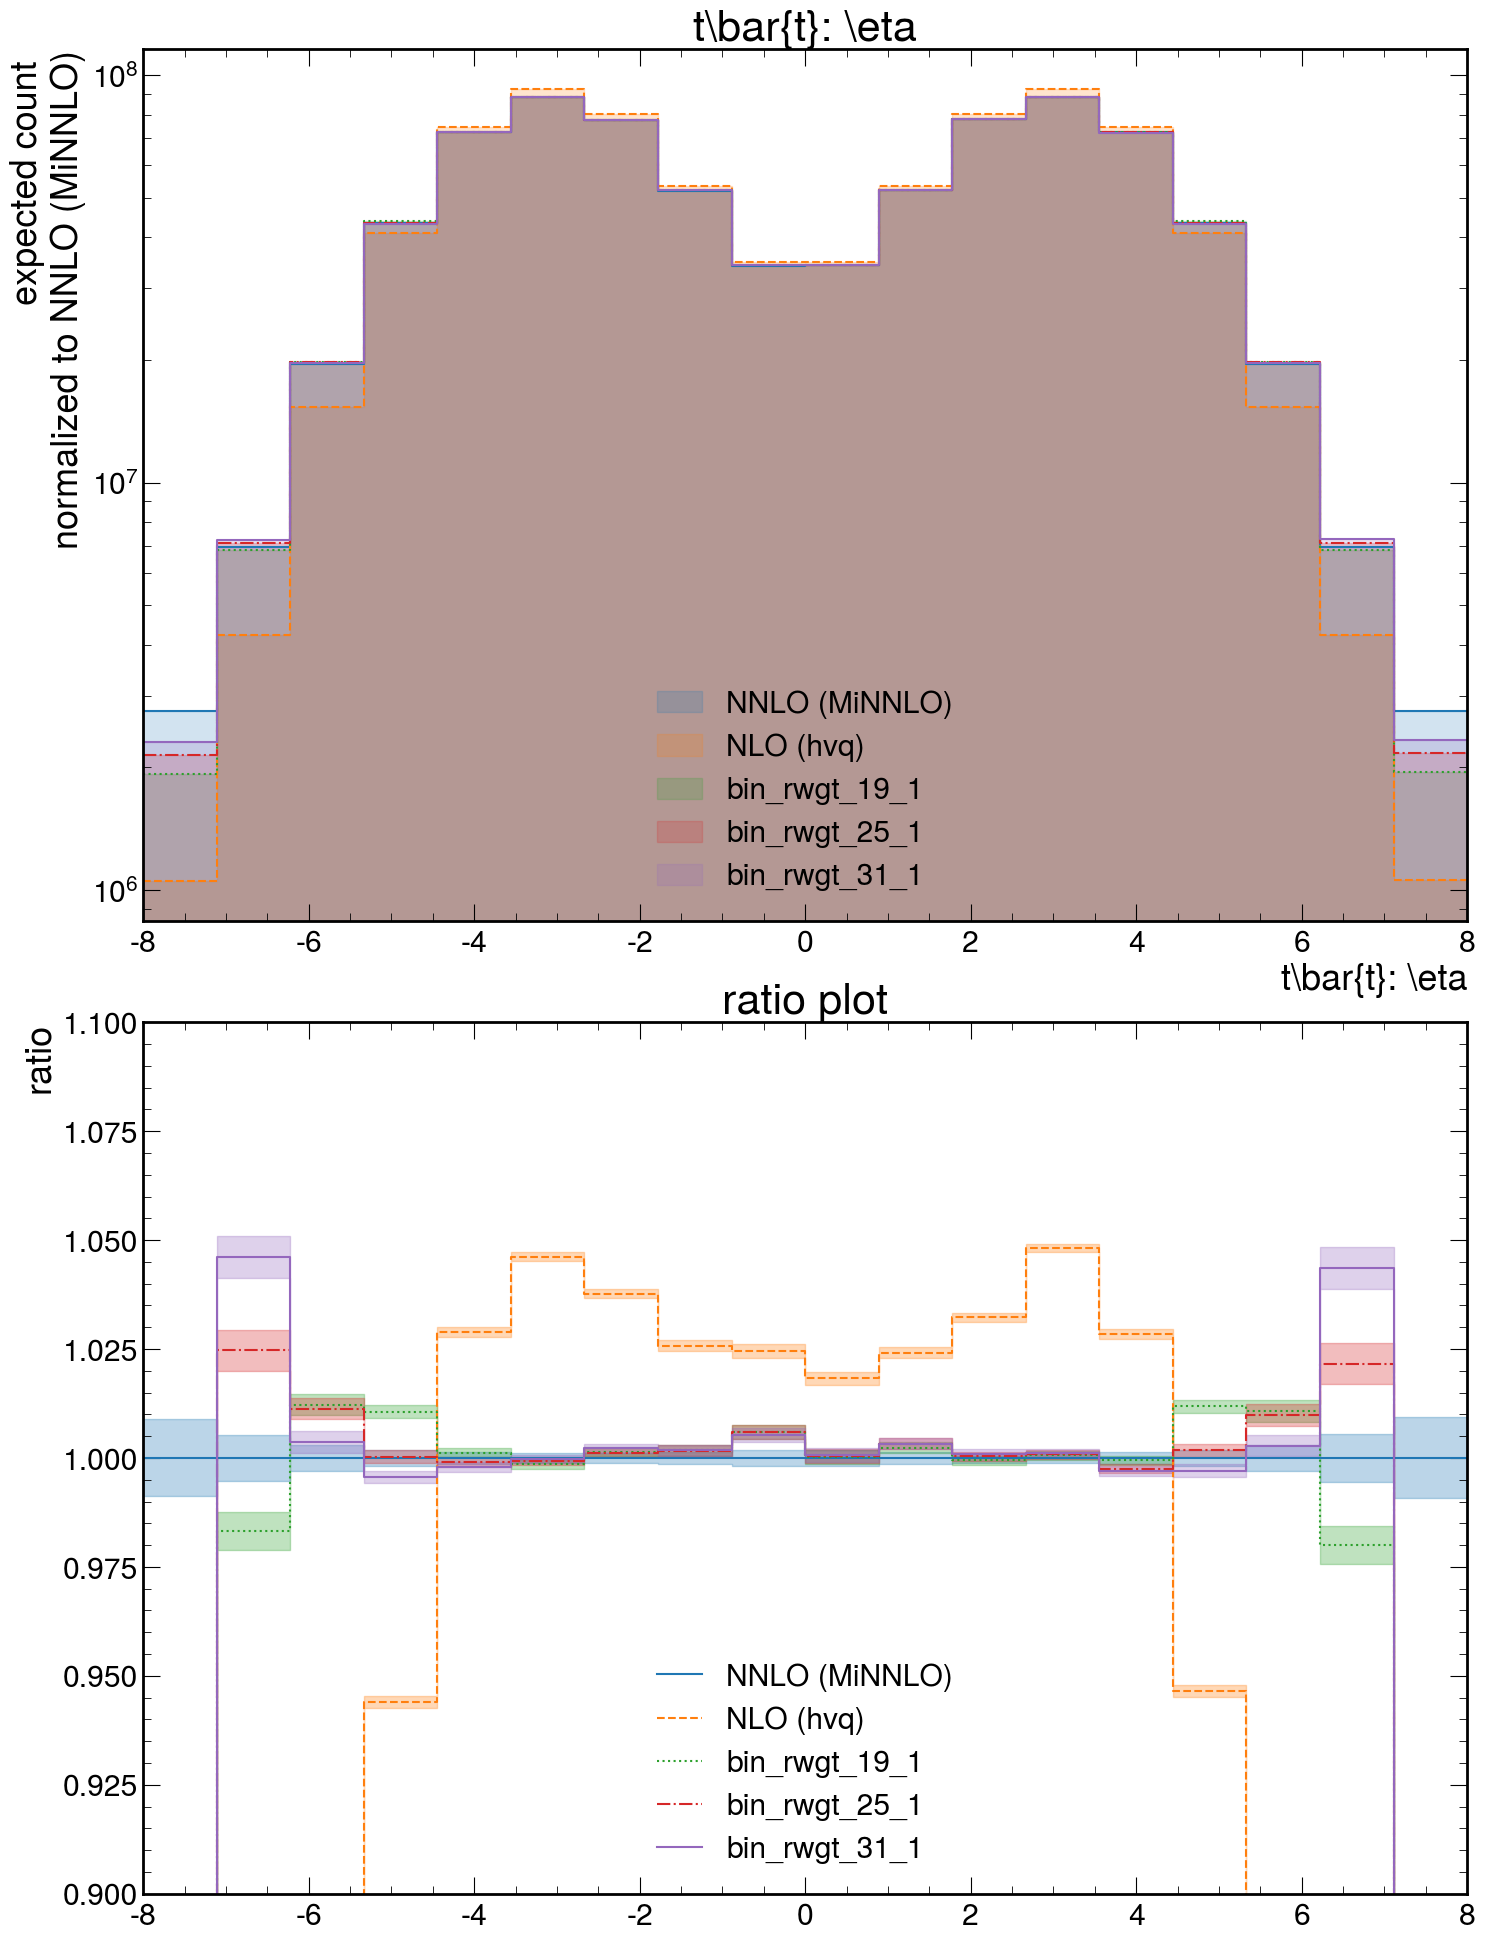

NNLO (MiNNLO): mean: 0.001, std: 3.417, max/min: 13.830049878532156/-13.20077537478709 
 Mean Absolute Error 0.0 
 Mean Relative Error 0.0 
 reduced chi square of 0.0 with p 1.0 
 compared to NNLO (MiNNLO)
NLO (hvq): mean: -0.000, std: 3.291, max/min: 10.023277969879556/-11.59612611504899 
 Mean Absolute Error 2441796.2402861733 
 Mean Relative Error 0.303153606196777 
 reduced chi square of 116.69454580853436 with p 0.0 
 compared to NNLO (MiNNLO)
bin_rwgt_19_1: mean: 0.000, std: 3.402, max/min: 10.023277969879556/-11.59612611504899 
 Mean Absolute Error 232502.73179288144 
 Mean Relative Error 0.052063027288774905 
 reduced chi square of 3.8856641572139976 with p 1.0181728772920213e-07 
 compared to NNLO (MiNNLO)
bin_rwgt_19_2: mean: -0.000, std: 3.384, max/min: 10.023277969879556/-11.59612611504899 
 Mean Absolute Error 623313.2700666687 
 Mean Relative Error 0.1134517303338528 
 reduced chi square of 16.029304201422224 with p 5.157959747488336e-48 
 compared to NNLO (MiNNLO)
bin_rw

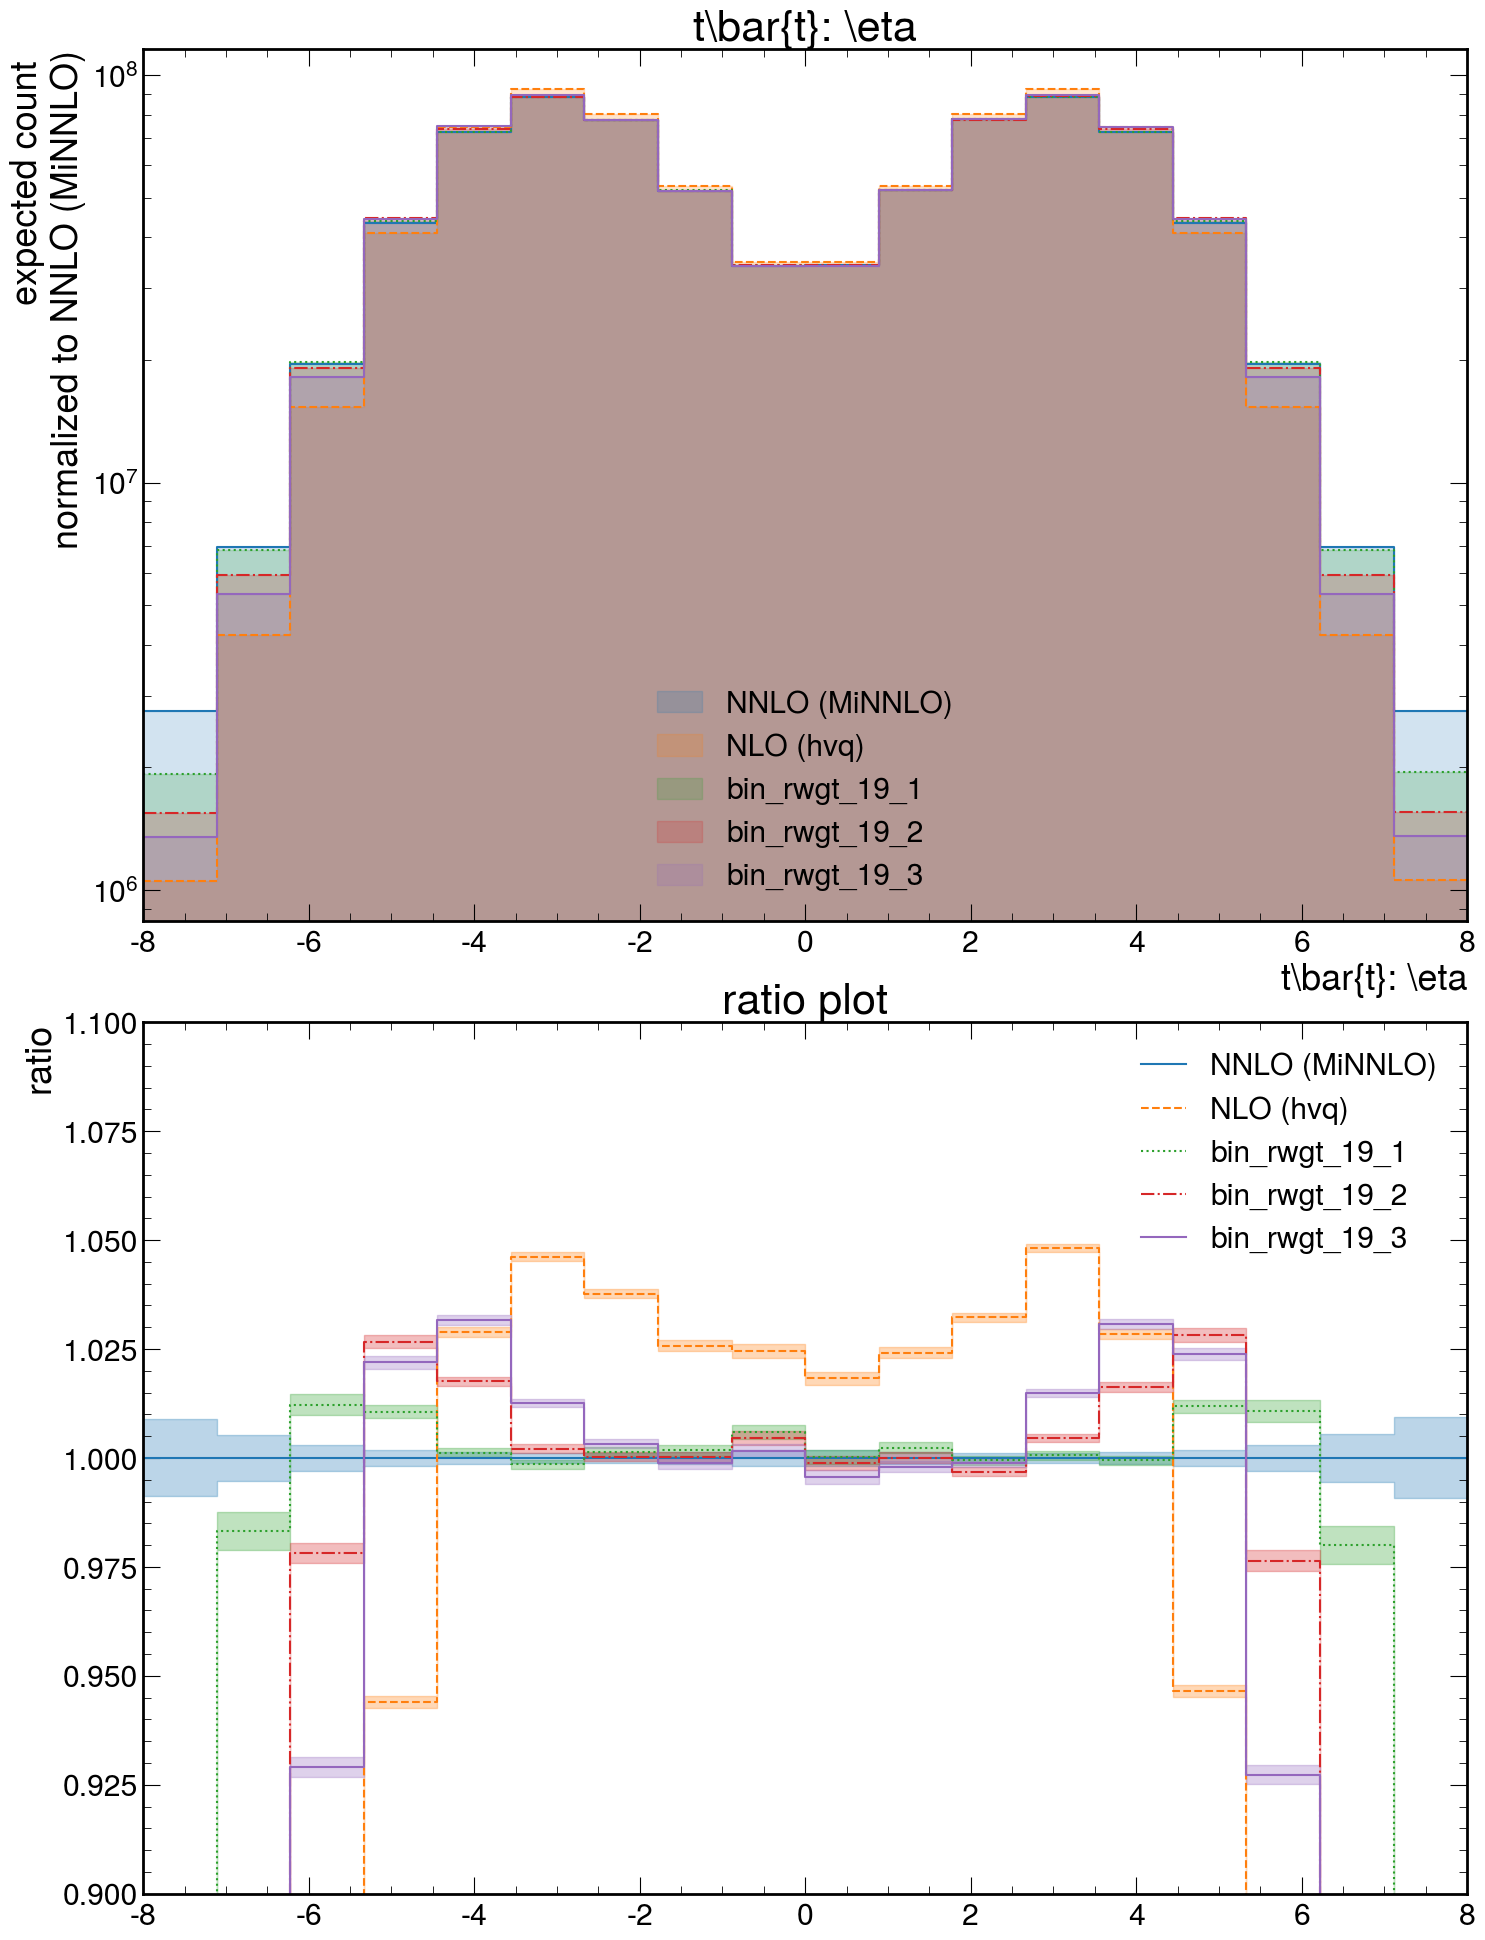

NNLO (MiNNLO): mean: 0.001, std: 3.417, max/min: 13.830049878532156/-13.20077537478709 
 Mean Absolute Error 0.0 
 Mean Relative Error 0.0 
 reduced chi square of 0.0 with p 1.0 
 compared to NNLO (MiNNLO)
NLO (hvq): mean: -0.000, std: 3.291, max/min: 10.023277969879556/-11.59612611504899 
 Mean Absolute Error 2441796.2402861733 
 Mean Relative Error 0.303153606196777 
 reduced chi square of 116.69454580853436 with p 0.0 
 compared to NNLO (MiNNLO)
bin_rwgt_25_1: mean: 0.000, std: 3.406, max/min: 10.023277969879556/-11.59612611504899 
 Mean Absolute Error 167151.28828650943 
 Mean Relative Error 0.03560114577089667 
 reduced chi square of 1.7228576462246934 with p 0.0319560682264966 
 compared to NNLO (MiNNLO)
bin_rwgt_25_2: mean: 0.000, std: 3.394, max/min: 10.023277969879556/-11.59612611504899 
 Mean Absolute Error 389130.4552332225 
 Mean Relative Error 0.08083635700347684 
 reduced chi square of 8.662196936732343 with p 8.415272693589649e-23 
 compared to NNLO (MiNNLO)
bin_rwgt_25_

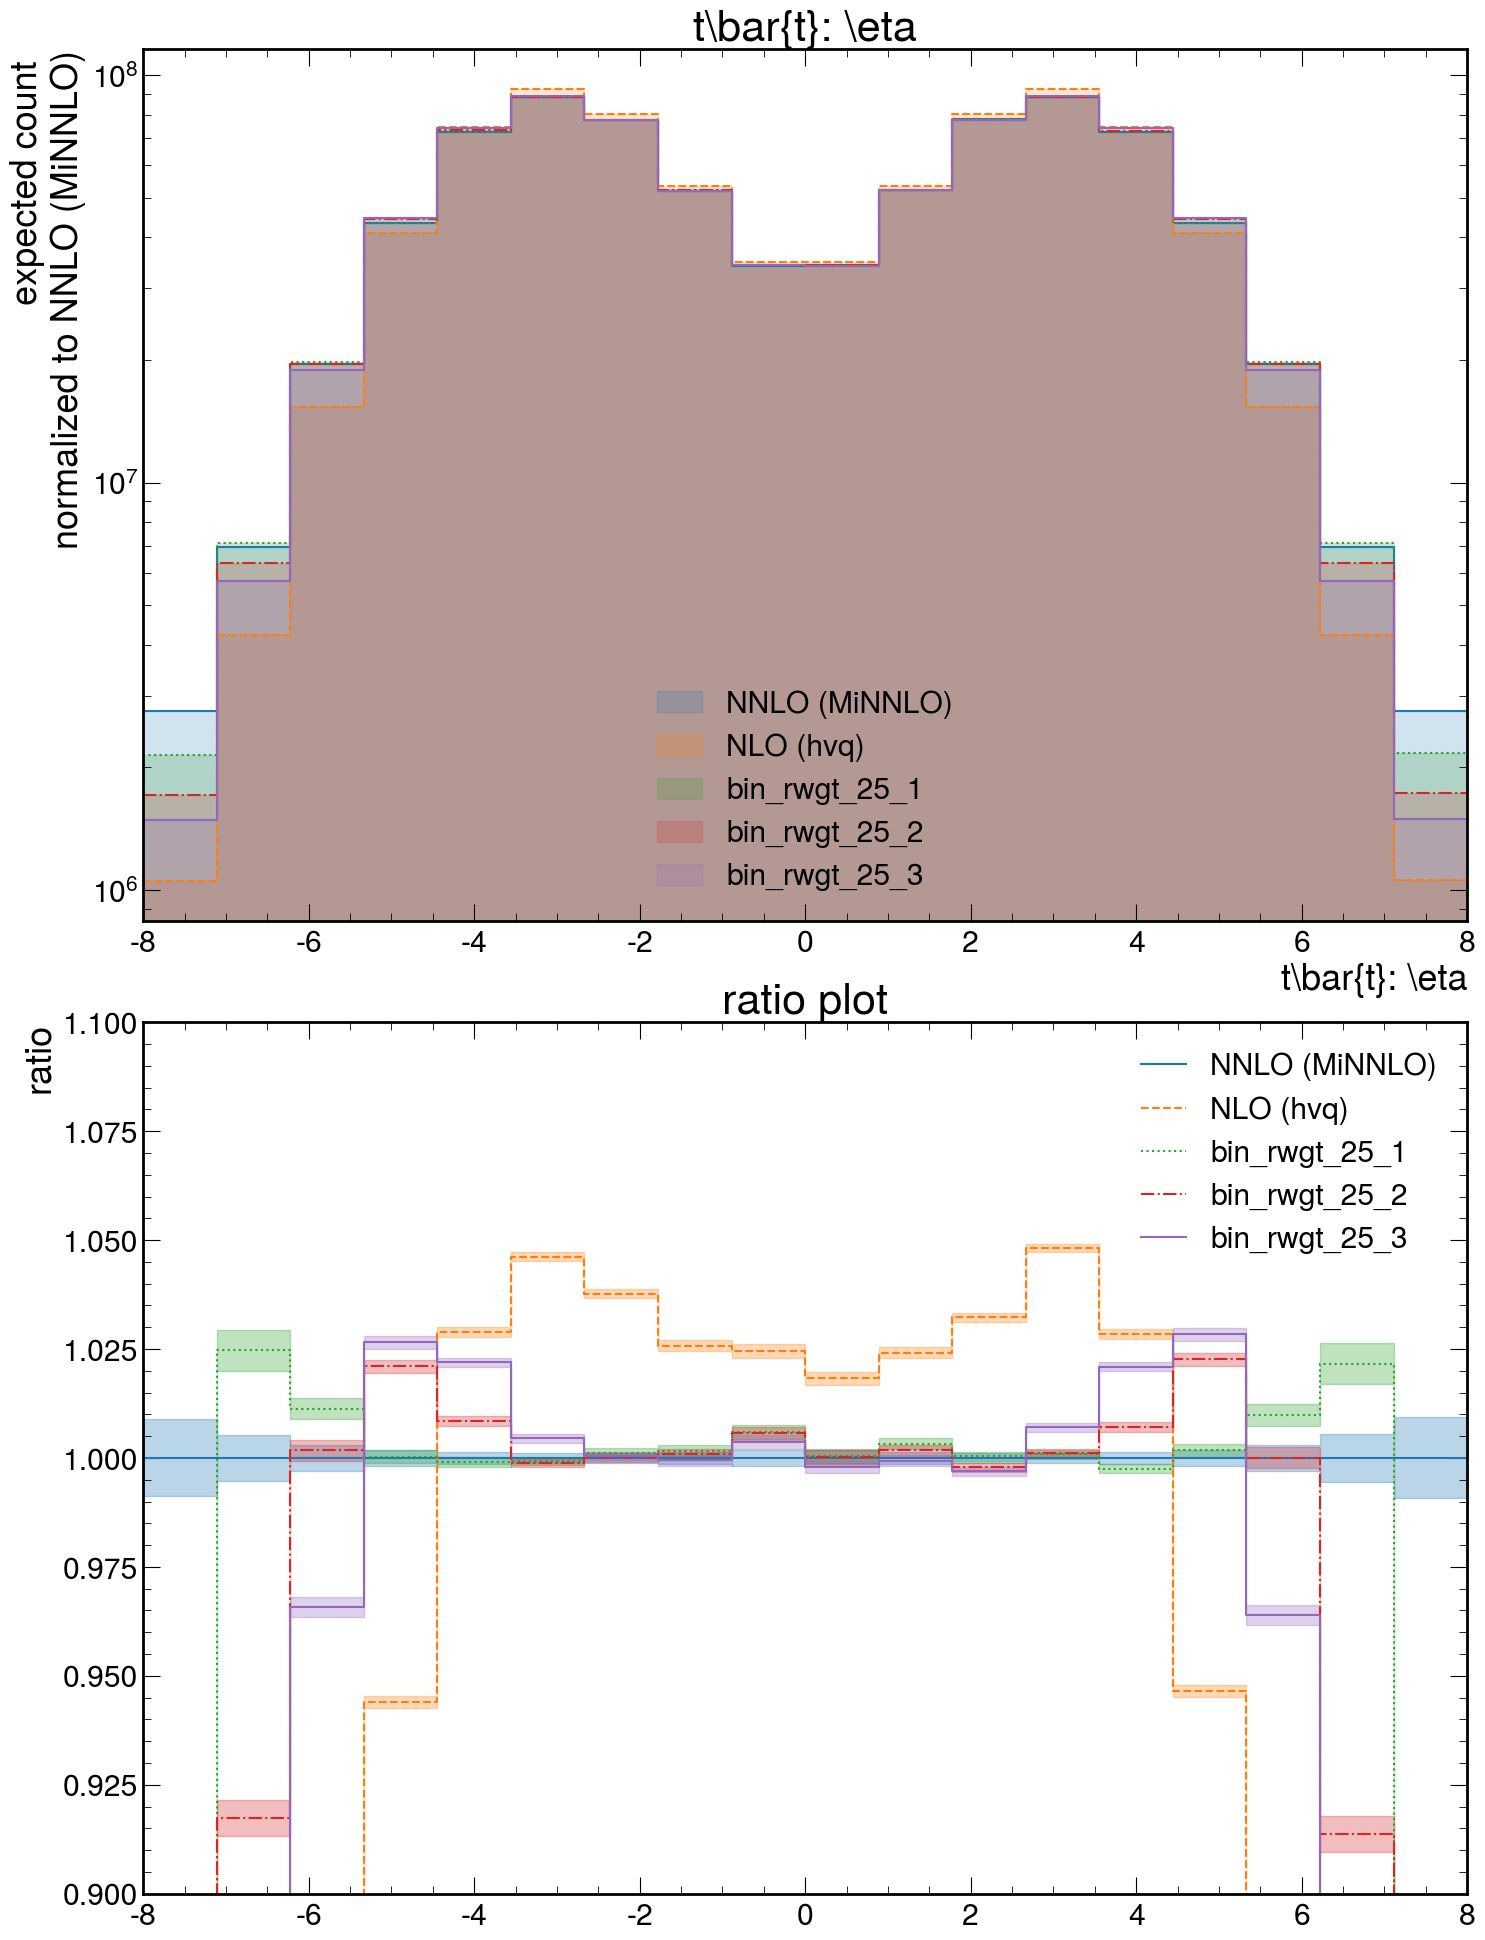

NNLO (MiNNLO): mean: 0.001, std: 3.417, max/min: 13.830049878532156/-13.20077537478709 
 Mean Absolute Error 0.0 
 Mean Relative Error 0.0 
 reduced chi square of 0.0 with p 1.0 
 compared to NNLO (MiNNLO)
NLO (hvq): mean: -0.000, std: 3.291, max/min: 10.023277969879556/-11.59612611504899 
 Mean Absolute Error 2441796.2402861733 
 Mean Relative Error 0.303153606196777 
 reduced chi square of 116.69454580853436 with p 0.0 
 compared to NNLO (MiNNLO)
bin_rwgt_31_1: mean: 0.001, std: 3.409, max/min: 10.023277969879556/-11.59612611504899 
 Mean Absolute Error 173318.0894654637 
 Mean Relative Error 0.027082905665063915 
 reduced chi square of 0.9039643164427219 with p 0.5690370800199169 
 compared to NNLO (MiNNLO)
bin_rwgt_31_2: mean: 0.000, std: 3.399, max/min: 10.023277969879556/-11.59612611504899 
 Mean Absolute Error 283479.9058565066 
 Mean Relative Error 0.06071295800982831 
 reduced chi square of 5.043983497258828 with p 3.5928922502570555e-11 
 compared to NNLO (MiNNLO)
bin_rwgt_31

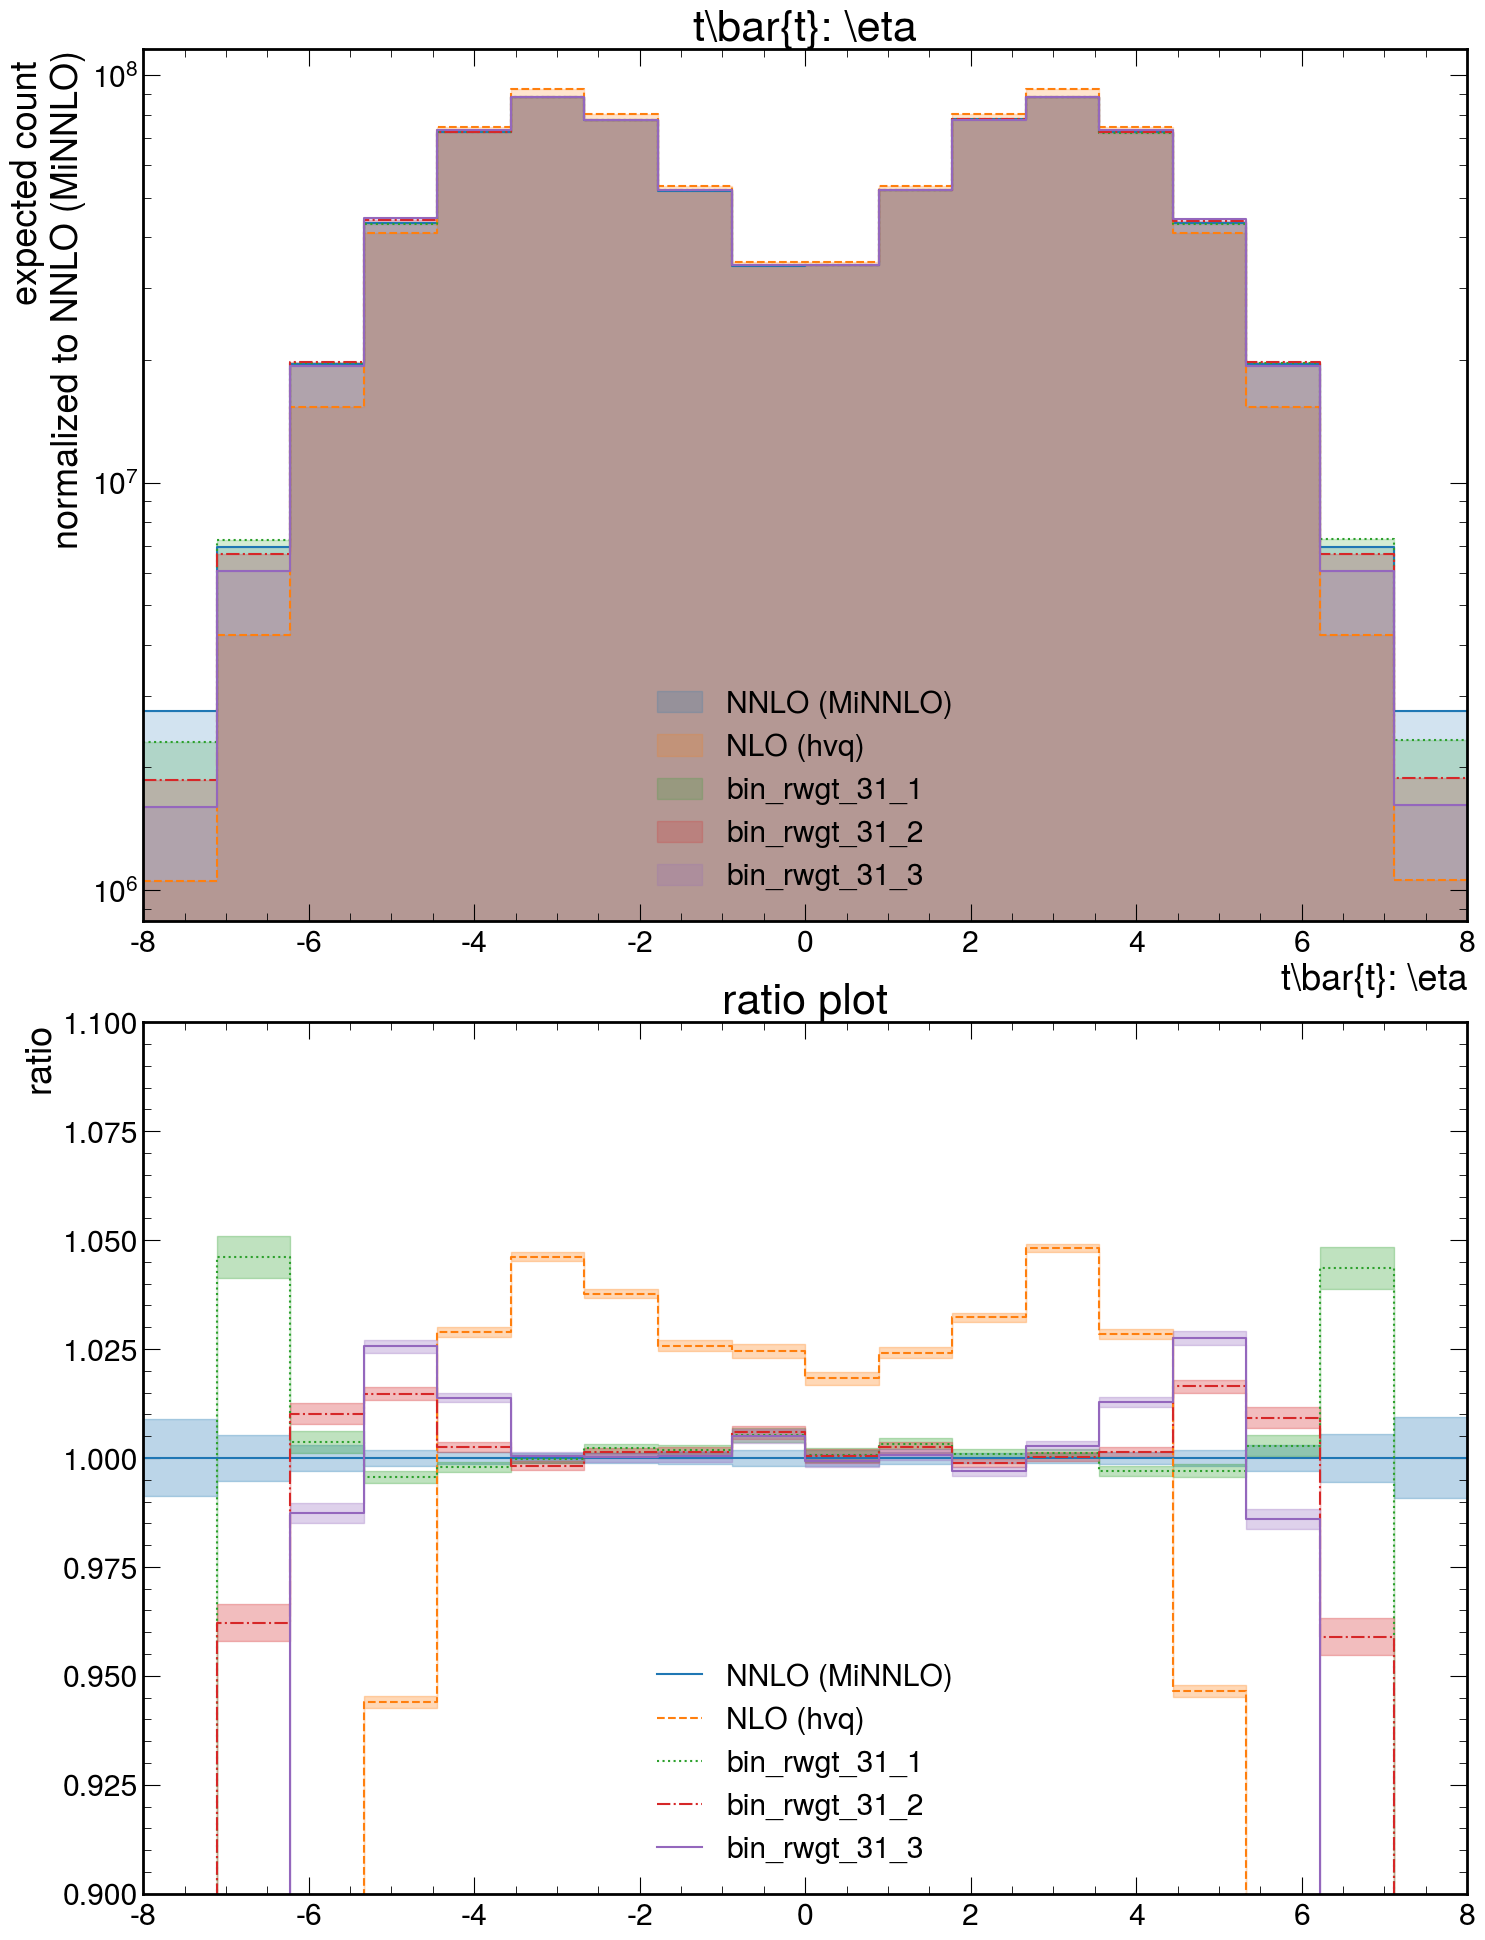

([0.0,
  2441796.2402861733,
  173318.0894654637,
  283479.9058565066,
  530872.5635837966],
 [0.0,
  116.69454580853436,
  0.9039643164427219,
  5.043983497258828,
  12.936088729589684],
 [1.0, 0.0, 0.5690370800199169, 3.5928922502570555e-11, 2.746224864682691e-37])

In [56]:
# plotting eta(tt)
# comparing different binning
DCTR.plot_ratio(args_n1, arg_index = 4, part_index = 0, start = -8, stop = 8, div=19, y_scale='log')

# comparing different n_neighs to take into consideration (gauss filter in bins)
DCTR.plot_ratio(args_19, arg_index = 4, part_index = 0, start = -8, stop = 8, div=19, y_scale='log')

DCTR.plot_ratio(args_25, arg_index = 4, part_index = 0, start = -8, stop = 8, div=19, y_scale='log')

DCTR.plot_ratio(args_31, arg_index = 4, part_index = 0, start = -8, stop = 8, div=19, y_scale='log')



NNLO (MiNNLO): mean: 120.981, std: 80.007, max/min: 2125.1621873385748/0.02517621005772228 
 Mean Absolute Error 0.0 
 Mean Relative Error 0.0 
 reduced chi square of 0.0 with p 1.0 
 compared to NNLO (MiNNLO)
NLO (hvq): mean: 122.756, std: 80.689, max/min: 2118.3017198949424/0.029502534939254157 
 Mean Absolute Error 886207.955367579 
 Mean Relative Error 0.03590752486628555 
 reduced chi square of 4.8086346463946965 with p 1.8742947752592505e-10 
 compared to NNLO (MiNNLO)
bin_rwgt_19_1: mean: 122.473, std: 80.672, max/min: 2118.3017198949424/0.029502534939254157 
 Mean Absolute Error 708429.3101831597 
 Mean Relative Error 0.03278820411649494 
 reduced chi square of 3.2399003389102994 with p 6.65672418024357e-06 
 compared to NNLO (MiNNLO)
bin_rwgt_25_1: mean: 122.452, std: 80.664, max/min: 2118.3017198949424/0.029502534939254157 
 Mean Absolute Error 696543.5833719119 
 Mean Relative Error 0.03240038020900055 
 reduced chi square of 3.137946327205866 with p 1.2594548341908331e-05 


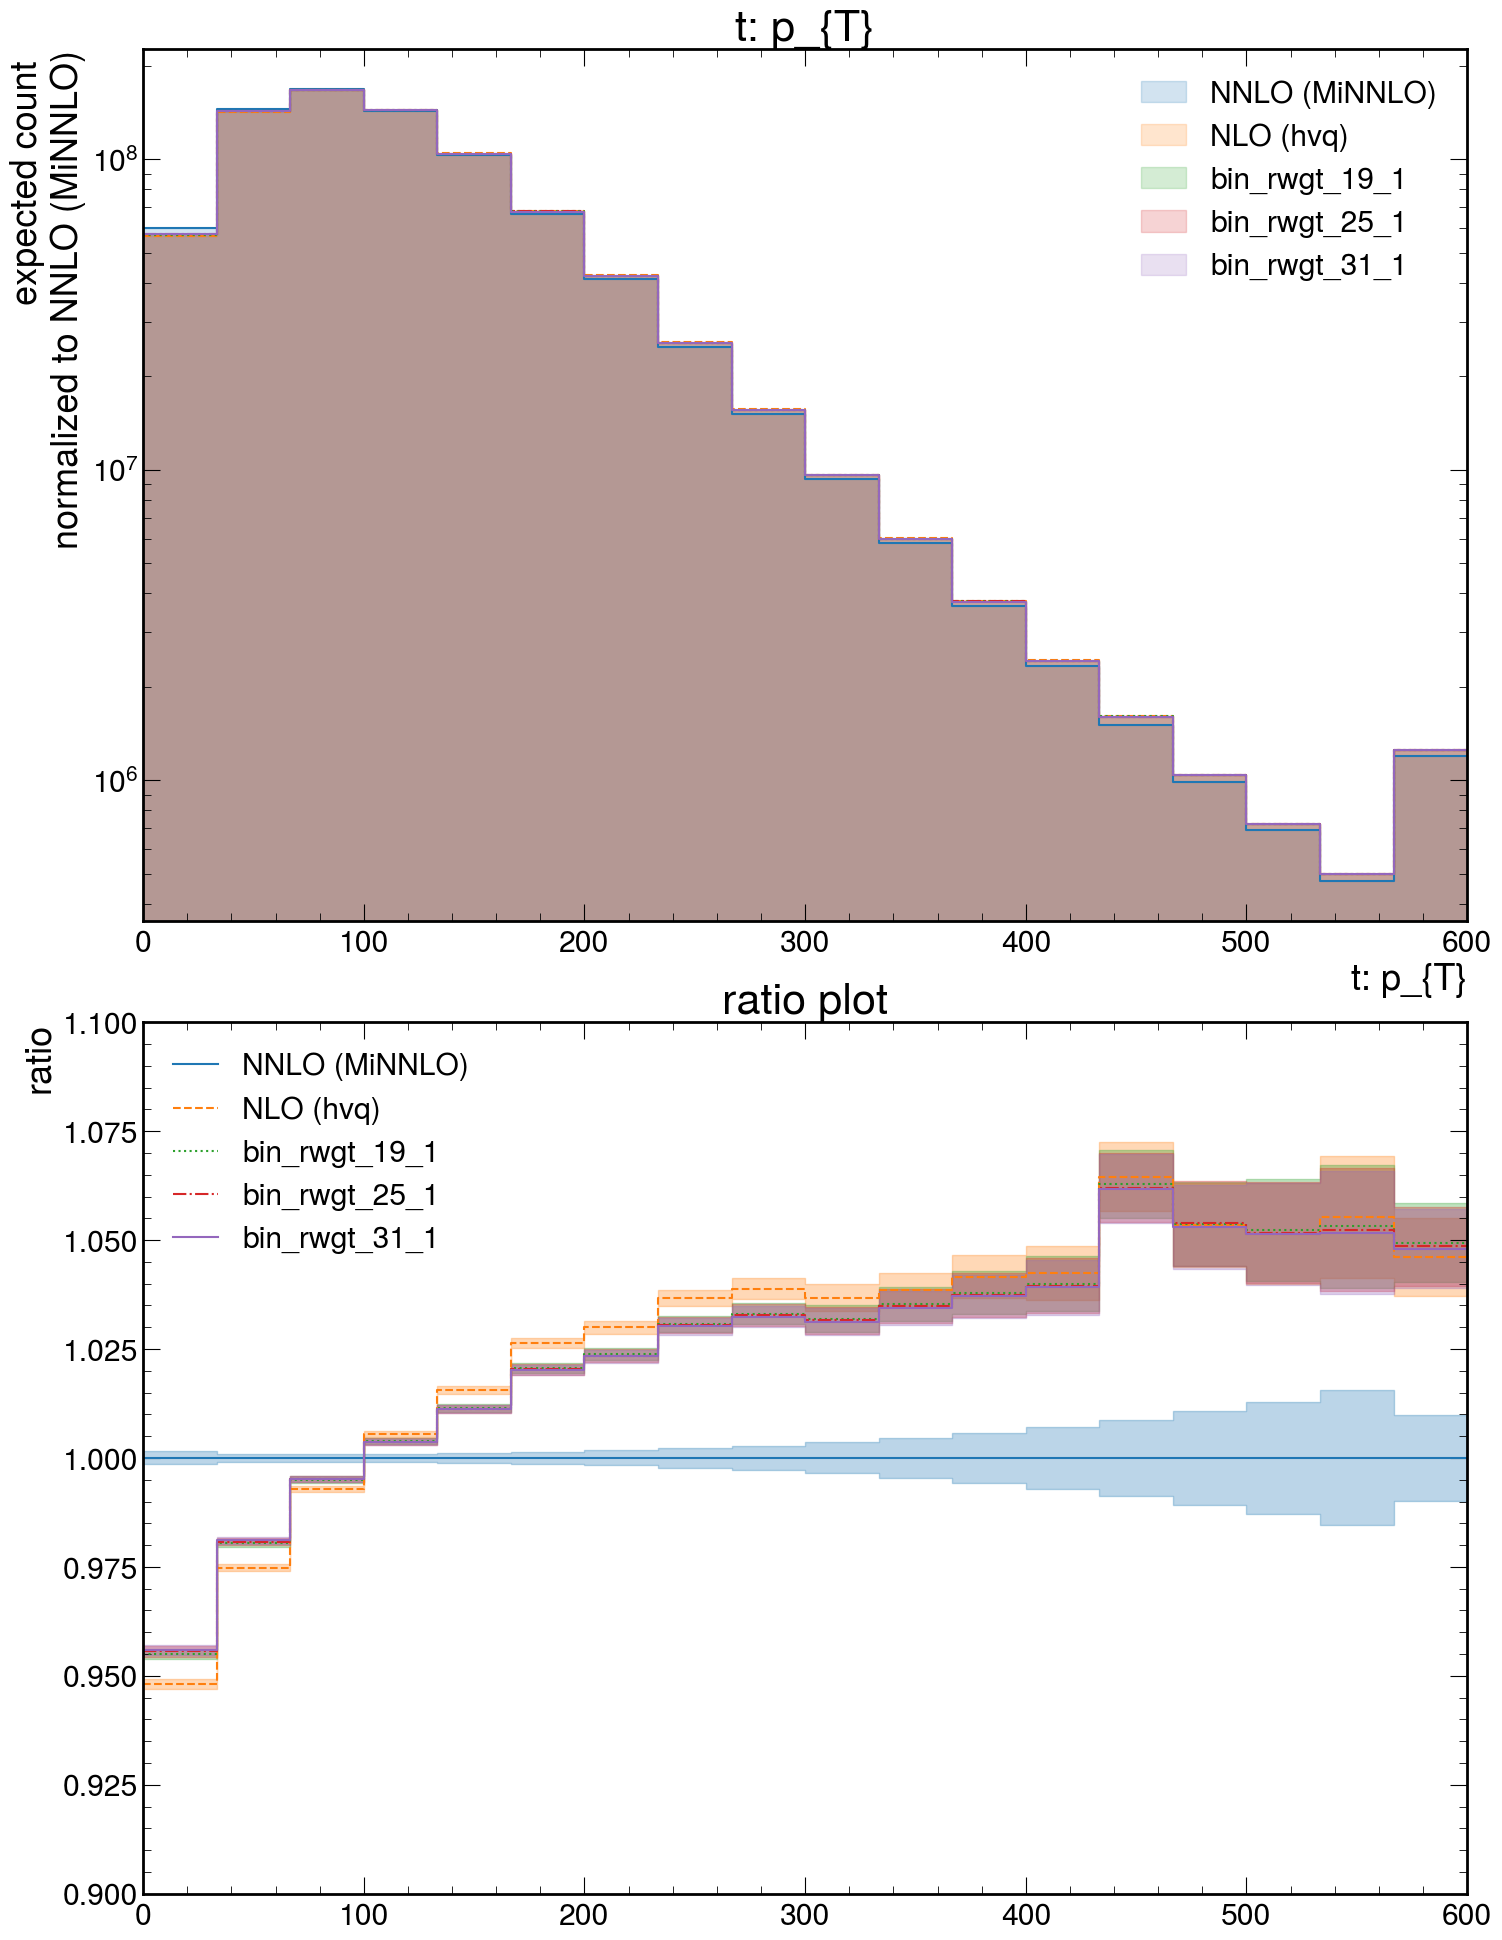

NNLO (MiNNLO): mean: 120.981, std: 80.007, max/min: 2125.1621873385748/0.02517621005772228 
 Mean Absolute Error 0.0 
 Mean Relative Error 0.0 
 reduced chi square of 0.0 with p 1.0 
 compared to NNLO (MiNNLO)
NLO (hvq): mean: 122.756, std: 80.689, max/min: 2118.3017198949424/0.029502534939254157 
 Mean Absolute Error 886207.955367579 
 Mean Relative Error 0.03590752486628555 
 reduced chi square of 4.8086346463946965 with p 1.8742947752592505e-10 
 compared to NNLO (MiNNLO)
bin_rwgt_19_1: mean: 122.473, std: 80.672, max/min: 2118.3017198949424/0.029502534939254157 
 Mean Absolute Error 708429.3101831597 
 Mean Relative Error 0.03278820411649494 
 reduced chi square of 3.2399003389102994 with p 6.65672418024357e-06 
 compared to NNLO (MiNNLO)
bin_rwgt_19_2: mean: 122.485, std: 80.640, max/min: 2118.3017198949424/0.029502534939254157 
 Mean Absolute Error 726762.9992799145 
 Mean Relative Error 0.03226170007627741 
 reduced chi square of 3.3861575385055604 with p 2.6360872001671876e-06 

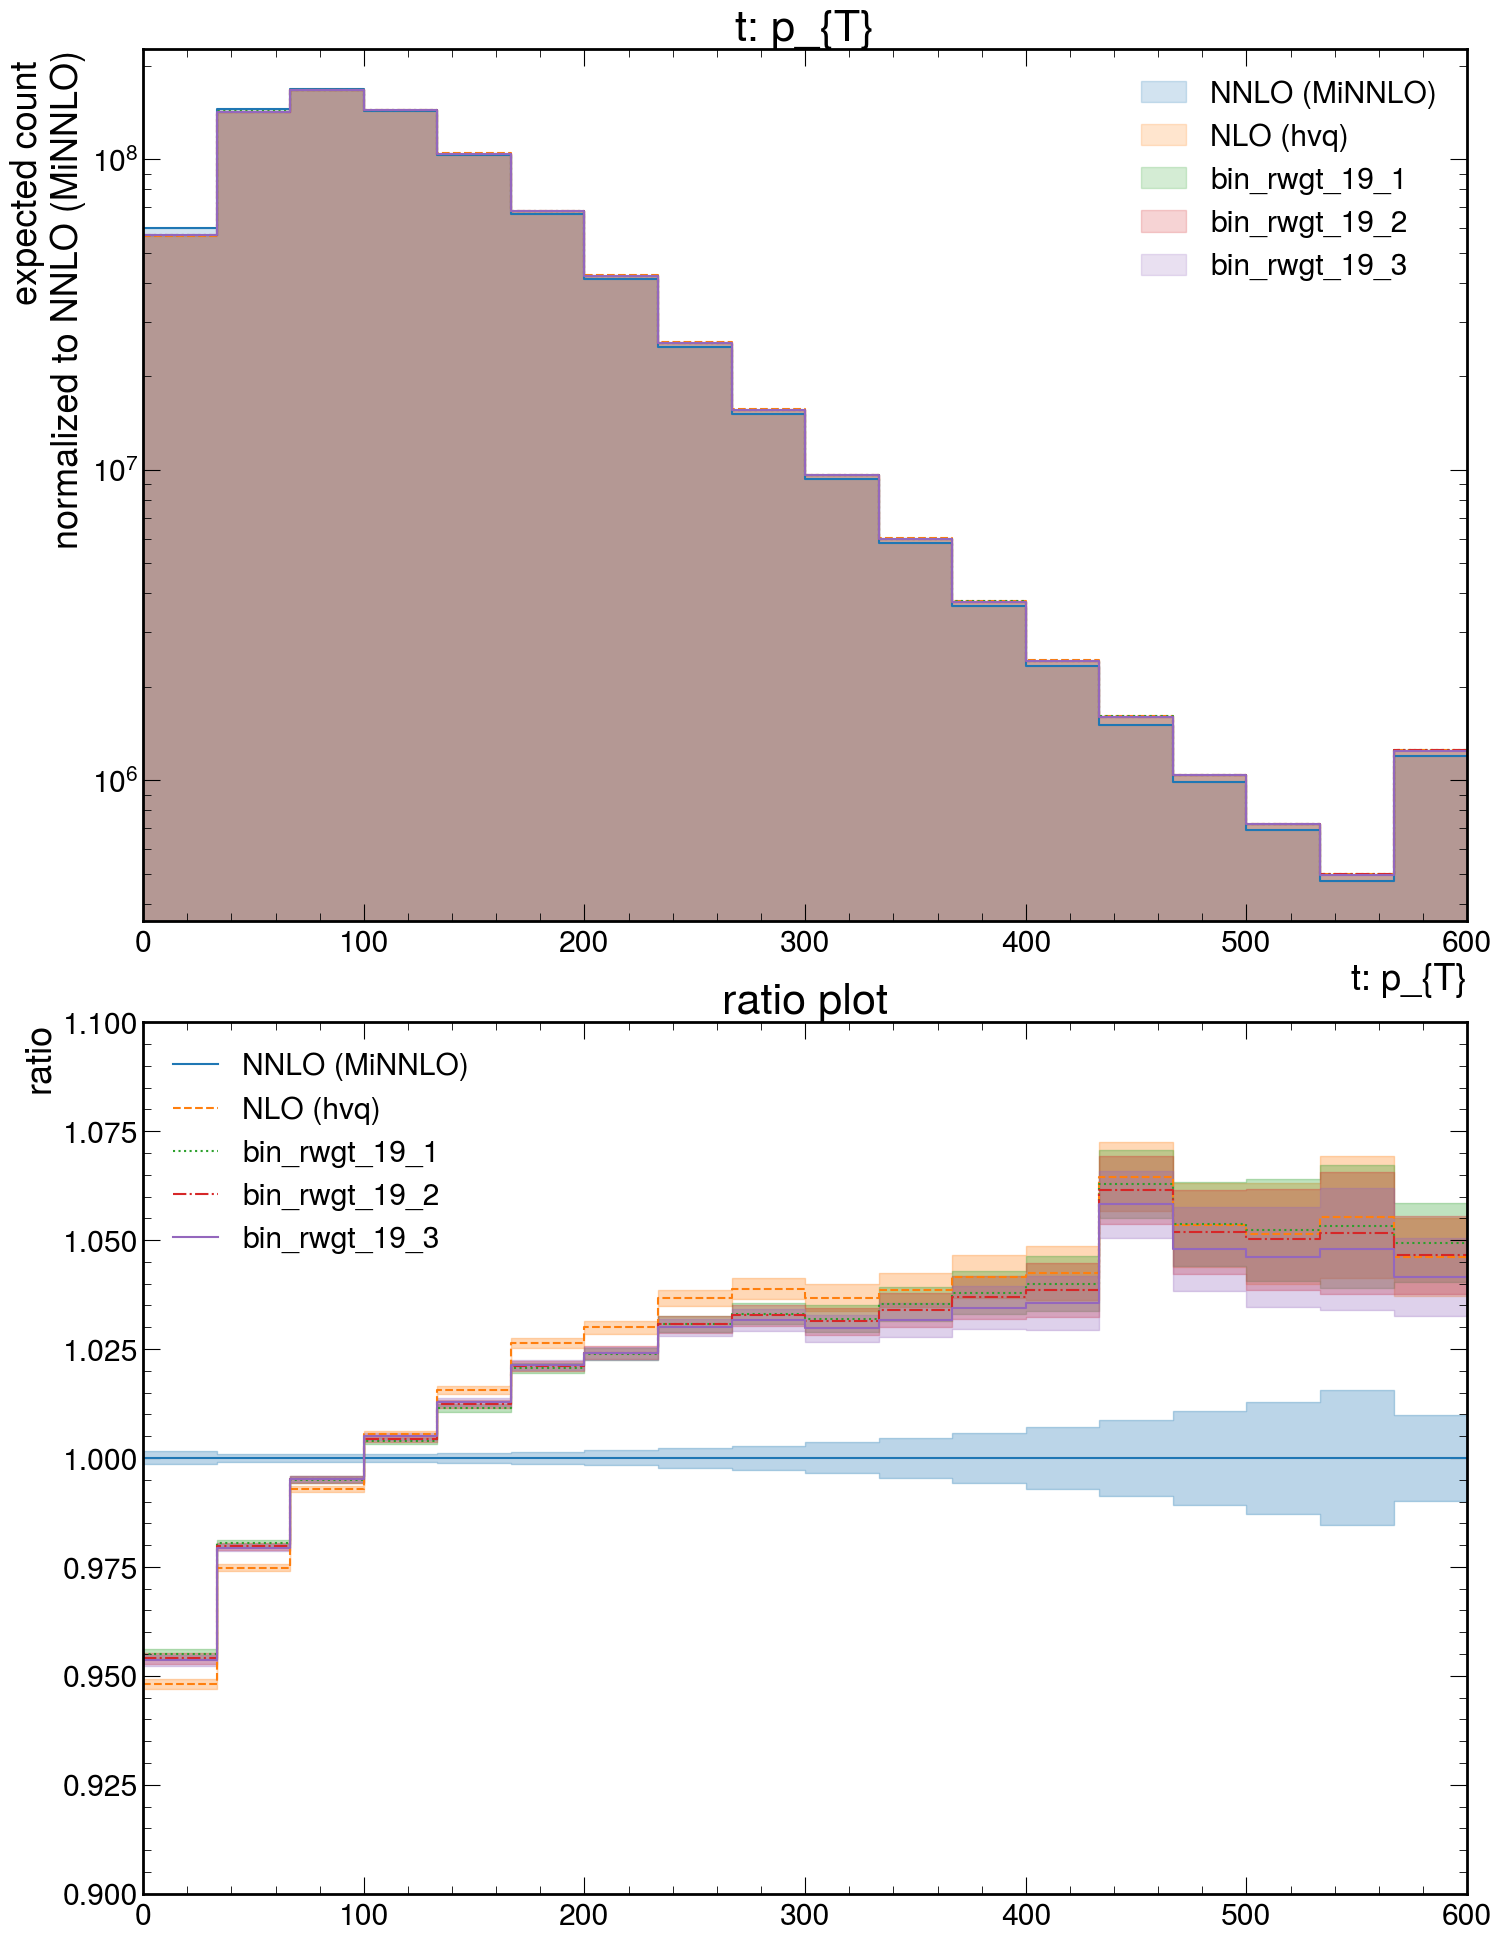

NNLO (MiNNLO): mean: 120.981, std: 80.007, max/min: 2125.1621873385748/0.02517621005772228 
 Mean Absolute Error 0.0 
 Mean Relative Error 0.0 
 reduced chi square of 0.0 with p 1.0 
 compared to NNLO (MiNNLO)
NLO (hvq): mean: 122.756, std: 80.689, max/min: 2118.3017198949424/0.029502534939254157 
 Mean Absolute Error 886207.955367579 
 Mean Relative Error 0.03590752486628555 
 reduced chi square of 4.8086346463946965 with p 1.8742947752592505e-10 
 compared to NNLO (MiNNLO)
bin_rwgt_25_1: mean: 122.452, std: 80.664, max/min: 2118.3017198949424/0.029502534939254157 
 Mean Absolute Error 696543.5833719119 
 Mean Relative Error 0.03240038020900055 
 reduced chi square of 3.137946327205866 with p 1.2594548341908331e-05 
 compared to NNLO (MiNNLO)
bin_rwgt_25_2: mean: 122.486, std: 80.662, max/min: 2118.3017198949424/0.029502534939254157 
 Mean Absolute Error 720488.8657116488 
 Mean Relative Error 0.03275297448045713 
 reduced chi square of 3.3448760765712353 with p 3.428380778278508e-06 

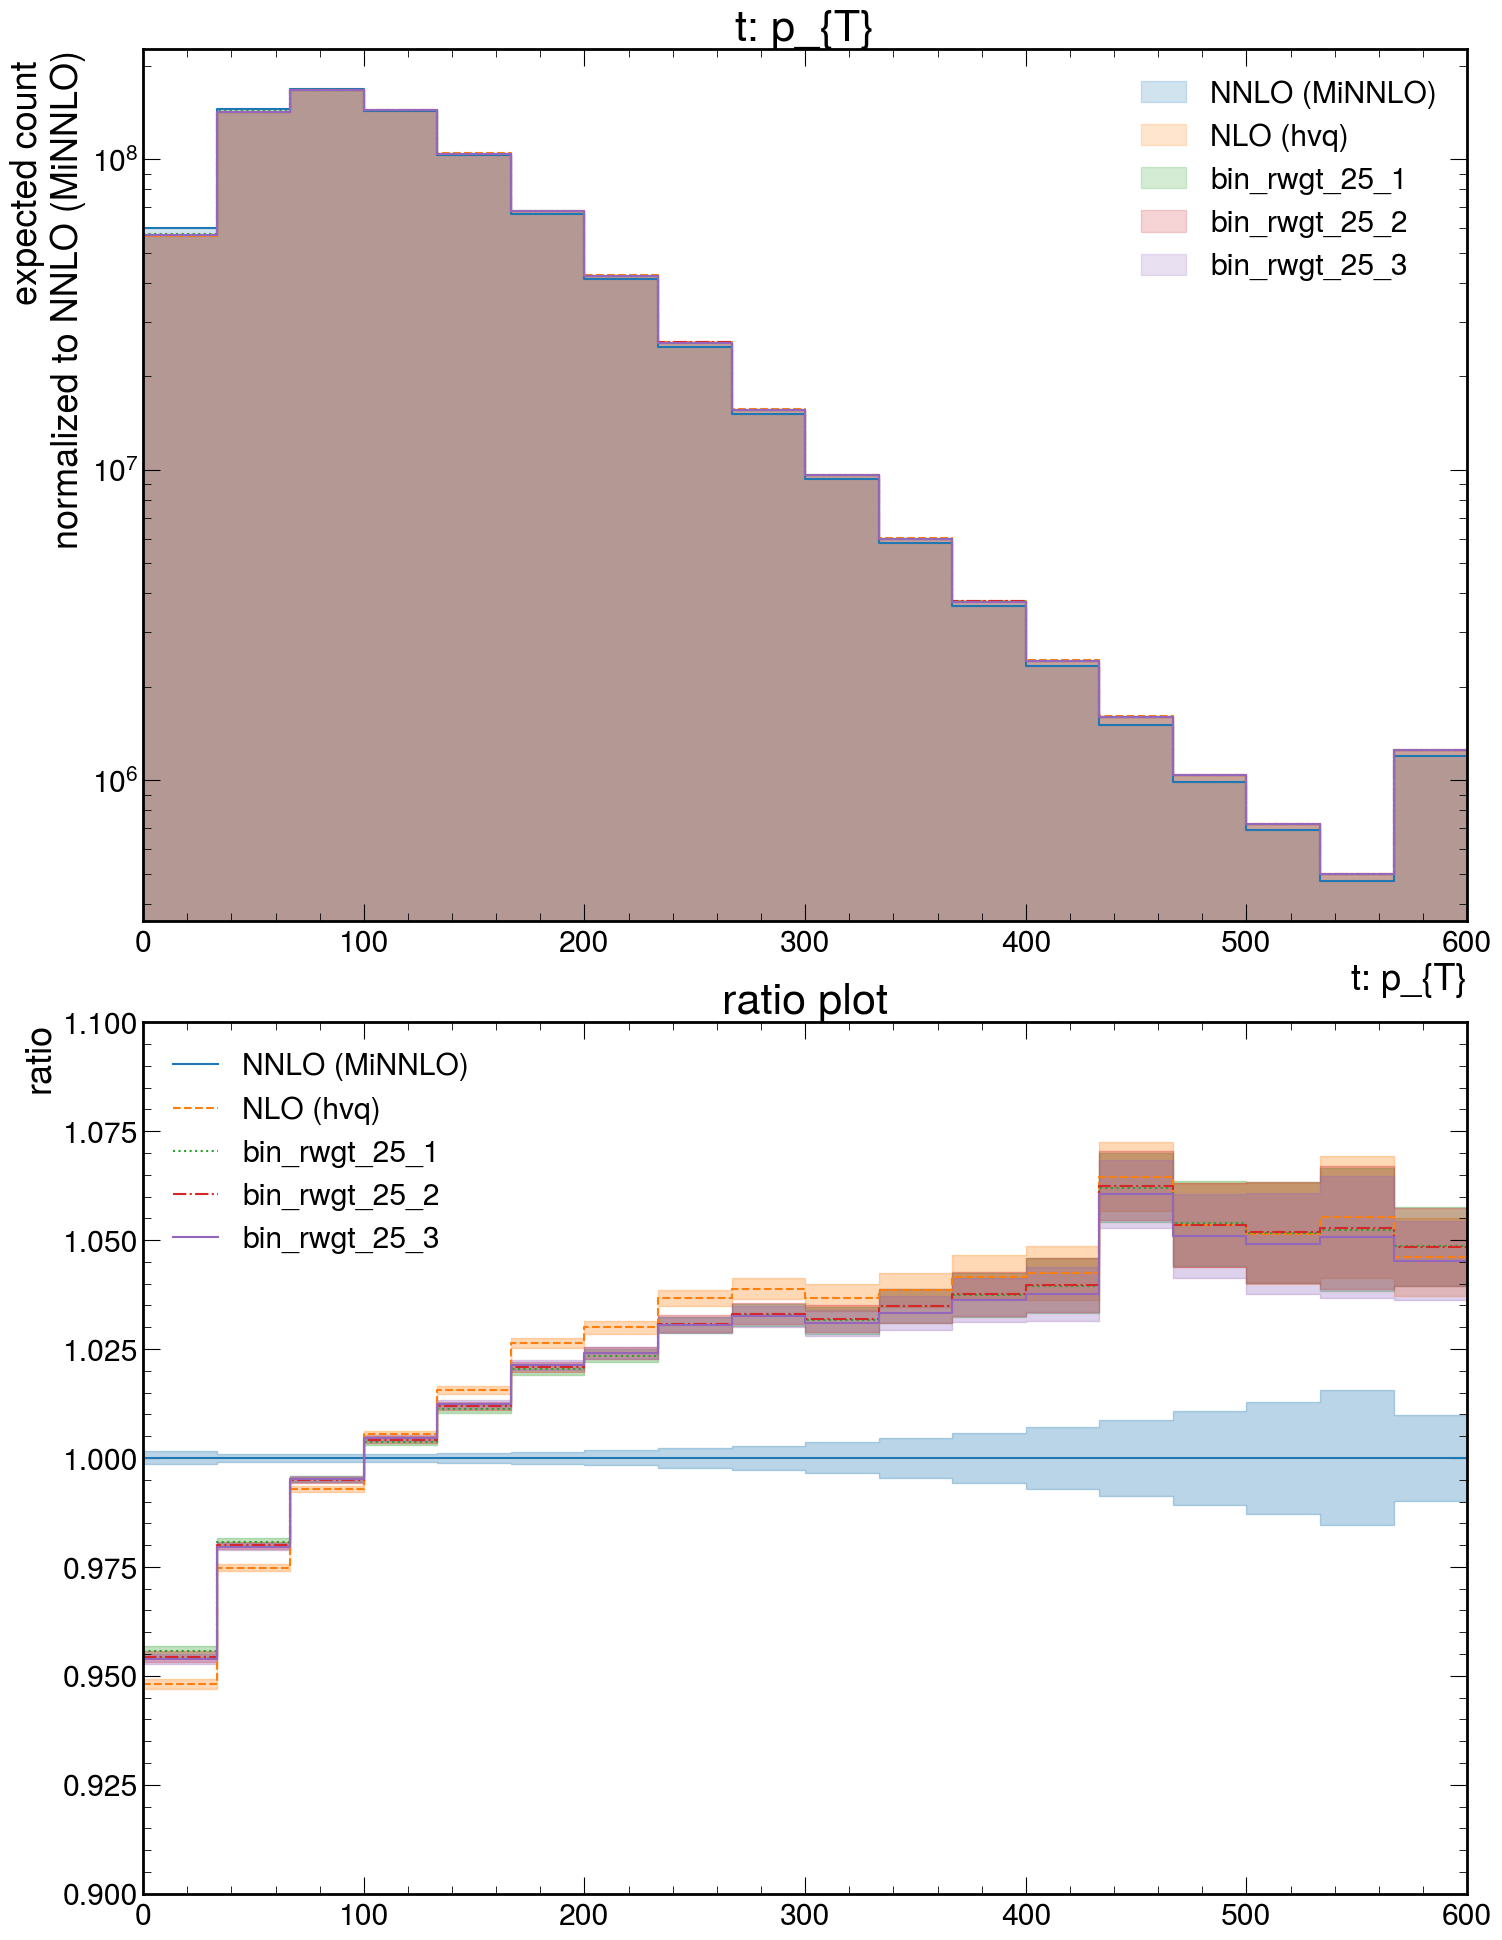

NNLO (MiNNLO): mean: 120.981, std: 80.007, max/min: 2125.1621873385748/0.02517621005772228 
 Mean Absolute Error 0.0 
 Mean Relative Error 0.0 
 reduced chi square of 0.0 with p 1.0 
 compared to NNLO (MiNNLO)
NLO (hvq): mean: 122.756, std: 80.689, max/min: 2118.3017198949424/0.029502534939254157 
 Mean Absolute Error 886207.955367579 
 Mean Relative Error 0.03590752486628555 
 reduced chi square of 4.8086346463946965 with p 1.8742947752592505e-10 
 compared to NNLO (MiNNLO)
bin_rwgt_31_1: mean: 122.436, std: 80.658, max/min: 2118.3017198949424/0.029502534939254157 
 Mean Absolute Error 688328.3503640485 
 Mean Relative Error 0.032082681707914375 
 reduced chi square of 3.0605064395882824 with p 2.0345342664825703e-05 
 compared to NNLO (MiNNLO)
bin_rwgt_31_2: mean: 122.482, std: 80.672, max/min: 2118.3017198949424/0.029502534939254157 
 Mean Absolute Error 714503.1175084742 
 Mean Relative Error 0.032901461849061855 
 reduced chi square of 3.295583293298585 with p 4.68572502196544e-06

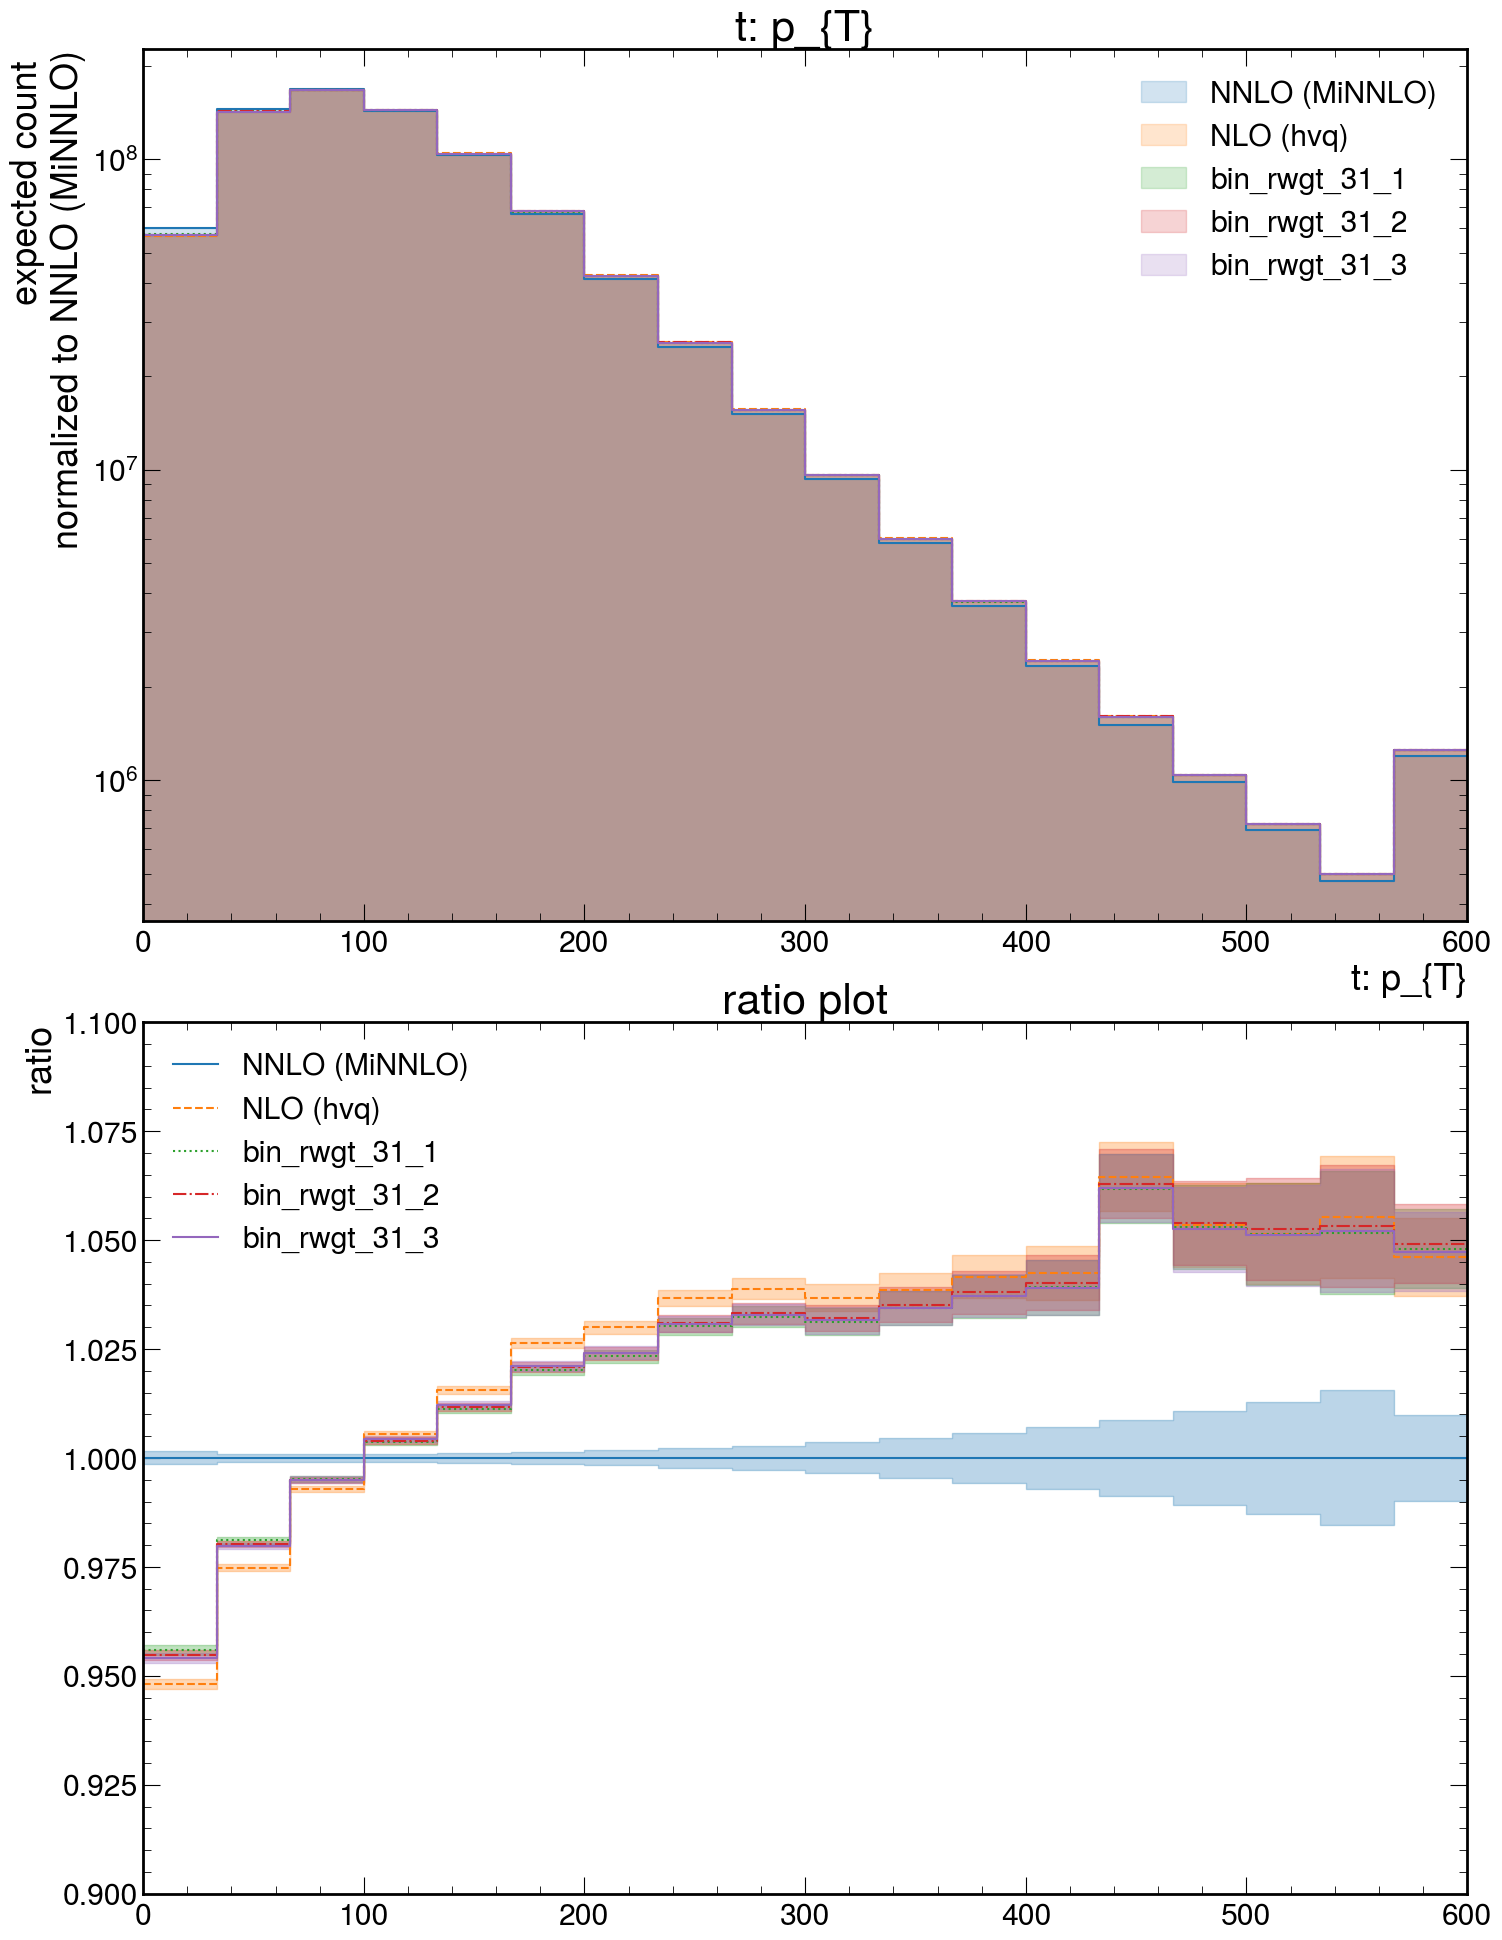

([0.0,
  886207.955367579,
  688328.3503640485,
  714503.1175084742,
  724992.6797297421],
 [0.0,
  4.8086346463946965,
  3.0605064395882824,
  3.295583293298585,
  3.376429208573543],
 [1.0,
  1.8742947752592505e-10,
  2.0345342664825703e-05,
  4.68572502196544e-06,
  2.804757253900287e-06])

In [57]:
# plotting p_T(t), since it was not included in one of the 2 dims
# comparing different binning
DCTR.plot_ratio(args_n1, arg_index = 0, part_index = 1, start = 0, stop = 600, div=19, y_scale='log')

# comparing different n_neighs to take into consideration (gauss filter in bins)
DCTR.plot_ratio(args_19, arg_index = 0, part_index = 1, start = 0, stop = 600, div=19, y_scale='log')

DCTR.plot_ratio(args_25, arg_index = 0, part_index = 1, start = 0, stop = 600, div=19, y_scale='log')

DCTR.plot_ratio(args_31, arg_index = 0, part_index = 1, start = 0, stop = 600, div=19, y_scale='log')

